In [5]:
# yunzhe and beatrice generated IsoQuant results from the WTC11 LRGASP data

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *
from proc_revisions.ss_sj_utils import *

In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
unfilt_ab = od+expand(config['lr']['cerberus']['ab'], species='human')[0] 
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]

ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]

# pp_summary = '../'+expand(config['data']['p_pred']['summary'], species='human')[0]
iq_cerberus_h5 = od+expand(config['lr']['isoquant']['cerberus']['ca_annot'], species='human', obs_col='sample')[0]


iq_gtf = od+expand(config['lr']['isoquant']['gtf'], species='human')[0]
iq_ics = od+expand(config['lr']['isoquant']['cerberus']['ics'], species='human')[0]
iq_ab = od+expand(config['lr']['isoquant']['novel_ab'], species='human')[0]
iq_filt_ab = od+expand(config['lr']['isoquant']['cerberus']['ab'], species='human')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'polya'
obs_col = 'sample'
go_gene_subset = 'protein_coding'
predom_iso_subset = 'protein_coding'
dist_gene_subset = 'protein_coding'

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]

## What % of ICs detected only in IQ have annotated microexons?

In [4]:
def get_iq_df_tpm(df, feat, min_tpm, gene_subset):
    dataset_cols = ['wtc11_1_3', 'wtc11_1_2', 'wtc11_1_1']
    df = df[dataset_cols+['annot_transcript_id']]
    if feat != 'triplet':
        df = add_feat(df, col='annot_transcript_id', kind=feat)
        df.drop('annot_transcript_id', inplace=True, axis=1)
        gb_col = feat
    else:
        gb_col = 'annot_transcript_id'
    df = df.groupby(gb_col).sum()
    df = df.loc[(df>=min_tpm).any(axis=1)]
    df.reset_index(inplace=True)
    
    if gene_subset:
        df['gid'] = df.ic.str.split('_', expand=True)[0]
        gene_df, _, _ = get_gtf_info(ver='v40_cerberus', how='gene', add_stable_gid=True)
        df = df.merge(gene_df[['gid_stable', 'biotype_category']], 
                      how='left',
                      left_on='gid',
                      right_on='gid_stable')
        if gene_subset == 'polya':
            gene_subset = get_polya_cats()
        else:
            gene_subset = [gene_subset]
        df = df.loc[df.biotype_category.isin(gene_subset)]
        df.drop(['gid', 'gid_stable', 'biotype_category'], axis=1, inplace=True)
    
    return df

iq_df = pd.read_csv(iq_filt_ab, sep='\t')
iq_df = get_iq_df_tpm(iq_df, 'ic', min_tpm=min_tpm, gene_subset=gene_subset)

tl_df = pd.read_csv(filt_ab, sep='\t')
tl_df, tids = get_tpm_table(tl_df, 
                         how='ic',
                         min_tpm=min_tpm,
                         gene_subset=gene_subset,
                         sample=['wtc11'])

Calculating ic TPM values
Subsetting for ['wtc11'] samples
Subsetting for polya genes
Enforcing minimum TPM
Total # ics detected: 145392
# ics >= 1 tpm: 47564
Applying gene type and novelty subset
Number of ics reported: 47357


In [5]:
# take mean of each library in dataset
tl_df['tl_mean_tpm'] = tl_df.mean(axis=1)
tl_df.reset_index(inplace=True)
tl_df['tl'] = True

iq_df['iq_mean_tpm'] = iq_df.mean(axis=1)
iq_df['iq'] = True
iq_df.reset_index(inplace=True)

df = iq_df.merge(tl_df, how='outer',
                 on='ic', suffixes=('_iq', ''))
df.iq.fillna(False, inplace=True)
df.tl.fillna(False, inplace=True)
df.fillna(0, inplace=True)

df['det_cat'] = df['tl'].astype(str)+'_'+df['iq'].astype(str)

df['tl_log2_avg_tpm'] = np.log2(df.tl_mean_tpm+1)
df['iq_log2_avg_tpm'] = np.log2(df.iq_mean_tpm+1)

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [6]:
iq_only_ics = df.loc[(df.iq==True)&\
                     (df.tl==False)].ic.tolist()

In [7]:
ic = cerberus.read(iq_cerberus_h5).ic.copy(deep=True)

In [9]:
iq_ic = ic.loc[ic.Name.isin(iq_only_ics)]

In [26]:
def add_ss_type_to_intron(df):
    """
    Given a bed-style df, add "ss_3" and "ss_5" columns to
    indicate which splice site each coordinate is used

    Parameters:
        df (pandas DataFrame): Bed-style DF of introns

    Returns:
        df (pandas DataFrame): Bed-style DF of introns w/ ss_3 and ss_5 columns added
    """

    df['ss_5'] = np.nan
    df.loc[df.Strand=='+', 'ss_5'] = df.loc[df.Strand=='+', ['Start', 'End']].min(axis=1)
    df.loc[df.Strand=='-', 'ss_5'] = df.loc[df.Strand=='-', ['Start', 'End']].max(axis=1)

    df['ss_3'] = np.nan
    df.loc[df.Strand=='+', 'ss_3'] = df.loc[df.Strand=='+', ['Start', 'End']].max(axis=1)
    df.loc[df.Strand=='-', 'ss_3'] = df.loc[df.Strand=='-', ['Start', 'End']].min(axis=1)

    assert len(df.loc[(df.ss_3<df.ss_5)&(df.Strand=='+')].index) == 0
    assert len(df.loc[(df.ss_3>df.ss_5)&(df.Strand=='-')].index) == 0

    return df


def intron_to_ss(df, id_cols=None):
    """
    Get splice site coordinates from intron coordinates in bed format

    Parameters:
        df (pandas DataFrame): Pandas DF of intron coordinates in bed format
        id_cols (None or list of str): List of columns to use as ss identifier
            during melt, otherwise None

    Returns:
        df (pandas DataFrame): Pandas DF of splice site coordinates in semi
            bed format (ie no end positions, just starts, as these are single bp)
    """


    # since these are intron coords, the start defines a 3' ss
    # and the end defines a 5' ss.
    # df.rename({'Start':'ss_3', 'End':'ss_5'}, axis=1, inplace=True)
#     df['ss_5'] = np.nan
#     df.loc[df.Strand=='+', 'ss_5'] = df.loc[df.Strand=='+', ['Start', 'End']].min(axis=1)
#     df.loc[df.Strand=='-', 'ss_5'] = df.loc[df.Strand=='-', ['Start', 'End']].max(axis=1)

#     df['ss_3'] = np.nan
#     df.loc[df.Strand=='+', 'ss_3'] = df.loc[df.Strand=='+', ['Start', 'End']].max(axis=1)
#     df.loc[df.Strand=='-', 'ss_3'] = df.loc[df.Strand=='-', ['Start', 'End']].min(axis=1)

    df = add_ss_type_to_intron(df)

    assert len(df.loc[(df.ss_3<df.ss_5)&(df.Strand=='+')].index) == 0
    assert len(df.loc[(df.ss_3>df.ss_5)&(df.Strand=='-')].index) == 0

    df.drop(['Start', 'End'], axis=1, inplace=True)

    if id_cols:
        id_cols += ['Chromosome', 'Strand']
    else:
        id_cols = ['Chromosome', 'Strand']

    df = df.melt(id_vars=id_cols,
                 var_name='ss_type',
                 value_name='Start')

    # remove duplicates, which would result from the same
    # ss being used in different sjs
    df = df.drop_duplicates()

    return df

def get_source_table(df):
    """
    Get a melted form table for each entry in a tss, ic, or tes table
    for each form of support for each triplet feature.

    Parameters:
        df (pandas DataFrame): DataFrame of tsss, ics, or tess

    Returns:
        df (pandas DataFrame): Long-form DataFrame of support for each tss, ic, or tes
    """
    keep_cols = ['Name', 'source']
    df = df[keep_cols].copy(deep=True)
    df['list_source'] = df.source.str.split(',')
    df = df.explode('list_source')
    df.drop('source', axis=1, inplace=True)

    return df

# chatgpt wrote this for me thanx chatgpt
def sequential_pairs(x, exon=False):
    """
    Get sequential pairs of tuples in list.
    Example: [1,2,3,4] -> [(1,2),(3,4)]
    """
    p = []
    if exon:
        start = 1
    else:
        start = 0
    for i in range(start, len(x) - 1, 2):
        p.append((x[i], x[i + 1]))
    return p

def explode_ic(ic, exon):
    """
    Explode an ic df to long form with splice junction entries
    """
    # remove the monoexonic entries
    ic = ic.loc[~(ic.Coordinates == '-')]
    
    # if we're getting exons, also get rid of 2-exon stuff
    if exon:
        ic = ic.loc[ic.Coordinates.str.count('-')>1]

    # explode into series of ss coords
    keep_cols = ['Chromosome', 'Coordinates',
                 'Strand', 'gene_id',
                 'Name']
    df = ic.copy(deep=True)
    df = df[keep_cols]
    df['ss_coords'] = df.Coordinates.str.split('-')

    # get pairs of sss to form sjs
    df['sj_coords'] = df.ss_coords.apply(sequential_pairs, exon=exon)
    df = df.explode('sj_coords')
    df.drop(['Coordinates', 'ss_coords'], axis=1, inplace=True)

    return df

def get_ss_sj_from_ic(ic, ref_sources, how, exon=False):
    ic = ic.copy(deep=True)

    # get coords of each splice site in each splice junction
    df = explode_ic(ic, exon)
    df['Start'] = df['sj_coords'].str[0].astype(int)
    df['End'] = df['sj_coords'].str[1].astype(int)
    df.drop('sj_coords', axis=1, inplace=True)

    # label sss as 5' or 3' and melt
    if how == 'ss':
        # assert len(df.loc[(df.Start>df.End)&(df.Strand=='+')].index) == 0
        # # since these are intron coords, the start defines a 3' ss
        # # and the end defines a 5' ss
        # df.rename({'Start':'ss_3', 'End':'ss_5'}, axis=1, inplace=True)
        # id_cols = ['Chromosome', 'Strand', 'gene_id', 'Name']
        # df = df.melt(id_vars=id_cols,
        #              var_name='ss_type',
        #              value_name='Start')
        df = intron_to_ss(df, ['gene_id', 'Name'])

    # for sjs, reorder according to min and max coords
    # in bed standard format
    elif how == 'sj':
        df['temp_Start'] = df.Start
        df['temp_End'] = df.End
        df['Start'] = df[['temp_Start', 'temp_End']].min(axis=1)
        df['End'] = df[['temp_Start', 'temp_End']].max(axis=1)
        df.drop(['temp_Start', 'temp_End'], axis=1, inplace=True)

    # df to hold ic to ss or sj info
    ic_df = df.copy(deep=True)

    # merge source info in w/ coord info
    df2 = get_source_table(ic)
    df = df.merge(df2, how='left', on=['Name'])

    # figure out novelty and source of each ss / sj
    df.drop('Name', axis=1, inplace=True)
    df.drop_duplicates(inplace=True)
    gb_cols = ['Chromosome', 'Strand', 'gene_id', 'Start']
    if how == 'ss':
        gb_cols += ['ss_type']
    elif how == 'sj':
        gb_cols += ['End']
    df.rename({'list_source': 'source'},
              axis=1, inplace=True)
    df['novelty'] = df.source.isin(ref_sources).map({True: 'Known',
                                                     False: 'Novel'})
    df = df.groupby(gb_cols).agg(','.join).reset_index()
    df = cerberus.update_novelty(df)

    # add novelty and support information to the ic / (ss or sj) df
    merge_cols = ['Chromosome', 'Strand', 'gene_id', 'Start']
    if how == 'ss':
        merge_cols += ['ss_type']
    elif how == 'sj':
        merge_cols += ['End']
    ic_df = ic_df.merge(df, how='left',
                        on=merge_cols)
    
    return df, ic_df

def get_exon_from_ic(ic, ref_sources):
    """
    Get an exon table from an intron chain table.
    Retain source and novelty information.

    Parameters:
        ic (pandas DataFrame): DataFrame formatted as cerberus ic table
        ref_sources (list of str): List of sources to use as references

    Returns:
        df (pandas DataFrame): DataFrame with entries for each exon
        ic_df (pandas DataFrame): DataFrame with entries for each exon /
            intron chain combination

    """
    return get_ss_sj_from_ic(ic, ref_sources, 'sj', exon=True)

def get_sj_from_ic(ic, ref_sources):
    """
    Get a splice junction table from an intron chain table.
    Retain source and novelty information.

    Parameters:
        ic (pandas DataFrame): DataFrame formatted as cerberus ic table
        ref_sources (list of str): List of sources to use as references

    Returns:
        df (pandas DataFrame): DataFrame with entries for each splice junction
        ic_df (pandas DataFrame): DataFrame with entries for each splice junction /
            intron chain combination

    """
    return get_ss_sj_from_ic(ic, ref_sources, 'sj')

def get_ss_from_ic(ic, ref_sources):
    """
    Get a splice site table from an intron chain table.
    Retain source and novelty information.

    Parameters:
        ic (pandas DataFrame): DataFrame formatted as cerberus ic table
        ref_sources (list of str): List of sources to use as references

    Returns:
        df (pandas DataFrame): DataFrame with entries for each splice site
        ic_df (pandas DataFrame): DataFrame with entries for each splice site /
            intron chain combination
    """
    return get_ss_sj_from_ic(ic, ref_sources, 'ss')

def get_fusion_sj_table(ab, ics, ref_ics, ver, include_novel=True):
    gtf_df, _, _ = get_gtf_info(ver=ver, how='gene', add_stable_gid=True)
    gtf_df = gtf_df[['gid_stable', 'gname']]
    gtf_df.head()

    talon_df = pd.read_csv(talon_filt_ab, sep='\t')
    talon_df['gid'] = cerberus.get_stable_gid(talon_df, 'annot_gene_id')

    fusion_gids = talon_df.loc[talon_df.gene_novelty=='Fusion', 'gid'].tolist()
    known_gids = talon_df.loc[talon_df.gene_novelty=='Known', 'gid'].tolist()

    df = pd.read_csv(ics, sep='\t')
    df['gene_id'] = df.Name.str.split('_', expand=True)[0]
    df['source'] = 'lapa'

    fusion_df = df.loc[df.gene_id.isin(fusion_gids)].copy(deep=True)
    # known_df = df.loc[df.gene_id.isin(known_gids)]
    known_df = pd.read_csv(ref_ics, sep='\t')
    known_df['gene_id'] = known_df.Name.str.split('_', expand=True)[0]
    known_df['source'] = 'lapa'

    _, f_sj_ic_df = get_sj_from_ic(fusion_df, ['lapa'])
    f_sj_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)

    _, k_sj_ic_df = get_sj_from_ic(known_df, ['lapa'])
    k_sj_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)

    f_sj_ic_df = f_sj_ic_df.merge(k_sj_ic_df, how='left', on=['Chromosome', 'Strand', 'Start', 'End'],
                              suffixes=('', '_known'))
    f_sj_ic_df['known'] = False
    f_sj_ic_df.loc[f_sj_ic_df.Name_known.notnull(), 'known'] = True

    # total # splice sjs / ic
    temp = f_sj_ic_df[['Name', 'Chromosome', 'Strand', 'Start', 'End']].copy(deep=True)
    temp['sj'] = temp.Name+temp.Chromosome+temp.Strand+temp.Start.astype(str)+temp.End.astype(str)
    temp = temp[['Name', 'sj']]
    temp = temp.groupby('Name').nunique().reset_index()
    temp.rename({'sj':'n_total_sj'}, axis=1, inplace=True)
    temp.head()

    # splice junctions / ic from each gene
    temp2 = f_sj_ic_df[['Name', 'known', 'Start', 'End', 'gene_id_known']].copy(deep=True)
    temp2.drop_duplicates(inplace=True)
    temp2.drop('End', axis=1, inplace=True)
    if include_novel == True:
        dropna = False
    else:
        dropna = True
    temp2 = temp2.groupby(['Name', 'known', 'gene_id_known'], dropna=dropna).count().reset_index()
    temp2.rename({'gene_id_known': 'gene_id', 'Start': 'n_sj'}, axis=1, inplace=True)
    temp2.head()

    # number each gene as 1' 2' or 3'
    temp2 = temp2.sort_values(by='n_sj', ascending=False)
    temp2['rank'] = temp2.sort_values(by='n_sj', ascending=False).groupby(['Name']).cumcount()+1
    temp2.head()

    # number of genes w/ intersecting sjs / ic
    temp3 = temp2[['Name', 'gene_id']].groupby('Name', dropna=dropna).nunique(dropna=dropna).reset_index()
    temp3.rename({'gene_id': 'n_genes'}, axis=1, inplace=True)
    temp3.head()

    temp5 = temp.merge(temp2, on='Name')
    temp5 = temp5.merge(temp3, on='Name')
    temp5['perc'] = (temp5['n_sj']/temp5['n_total_sj'])*100
    return f_sj_ic_df, temp5

def get_fusion_ss_table(ab, gtf, ref_ics, ver, include_novel=True):
    gtf_df, _, _ = get_gtf_info(ver=ver, how='gene', add_stable_gid=True)
    gtf_df = gtf_df[['gid_stable', 'gname']]
    gtf_df.head()

    talon_df = pd.read_csv(ab, sep='\t')
    talon_df['gid'] = cerberus.get_stable_gid(talon_df, 'annot_gene_id')

    fusion_gids = talon_df.loc[talon_df.gene_novelty=='Fusion', 'gid'].tolist()
    known_gids = talon_df.loc[talon_df.gene_novelty=='Known', 'gid'].tolist()

    # df = pd.read_csv(ics, sep='\t')
    # df['gene_id'] = df.Name.str.split('_', expand=True)[0]
    # df['source'] = 'lapa'
    df = pr.read_gtf(gtf, rename_attr=True, duplicate_attr=True)
    df = cerberus.get_ic(df)
    df.rename({'transcript_id':'Name', 'ic': 'Coordinates'}, axis=1, inplace=True)
    df['source'] = 'lapa'


    fusion_df = df.loc[df.gene_id.isin(fusion_gids)].copy(deep=True)
    known_df = pd.read_csv(ref_ics, sep='\t')
    known_df['gene_id'] = known_df.Name.str.split('_', expand=True)[0]
    known_df['source'] = 'lapa'

    _, f_ss_ic_df = get_ss_from_ic(fusion_df, ['lapa'])
    f_ss_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)

    _, k_ss_ic_df = get_ss_from_ic(known_df, ['lapa'])
    k_ss_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)

    f_ss_ic_df = f_ss_ic_df.merge(k_ss_ic_df, how='left', on=['Chromosome', 'Strand', 'Start', 'ss_type'],
                              suffixes=('', '_known'))
    f_ss_ic_df['known'] = False
    f_ss_ic_df.loc[f_ss_ic_df.Name_known.notnull(), 'known'] = True

    # total # splice sss / ic
    temp = f_ss_ic_df[['Name', 'Chromosome', 'Strand', 'Start']].copy(deep=True)
    temp['ss'] = temp.Name+temp.Chromosome+temp.Strand+temp.Start.astype(str)
    temp = temp[['Name', 'ss']]
    temp = temp.groupby('Name').nunique().reset_index()
    temp.rename({'ss':'n_total_ss'}, axis=1, inplace=True)
    temp.head()

    # splice sites / ic from each gene
    temp2 = f_ss_ic_df[['Name', 'known', 'Start', 'gene_id_known']].copy(deep=True)
    temp2.drop_duplicates(inplace=True)
    if include_novel == True:
        dropna = False
    else:
        dropna = True
    temp2 = temp2.groupby(['Name', 'known', 'gene_id_known'], dropna=dropna).count().reset_index()
    temp2.rename({'gene_id_known': 'gene_id', 'Start': 'n_ss'}, axis=1, inplace=True)
    temp2.head()

    # number each gene as 1' 2' or 3'
    temp2 = temp2.sort_values(by='n_ss', ascending=False)
    temp2['rank'] = temp2.sort_values(by='n_ss', ascending=False).groupby(['Name']).cumcount()+1
    temp2.head()

    # number of genes w/ intersecting sss / ic
    temp3 = temp2[['Name', 'gene_id']].groupby('Name', dropna=dropna).nunique(dropna=dropna).reset_index()
    temp3.rename({'gene_id': 'n_genes'}, axis=1, inplace=True)
    temp3.head()

    temp5 = temp.merge(temp2, on='Name')
    temp5 = temp5.merge(temp3, on='Name')
    temp5['perc'] = (temp5['n_ss']/temp5['n_total_ss'])*100
    return f_ss_ic_df, temp5, fusion_df

def fix_talon_fusion_transcripts(talon_ab,
                                 talon_filt_ab,
                                 talon_gtf,
                                 ref_ics,
                                 ref_gtf,
                                 wc,
                                 ofile_gtf,
                                 ofile_ab):
    """
    Fix fusion gene assignments based on the ss concordance between
    annotated (v29 or vM21) transcripts. Update gene counts accordingly.
    * If a "fusion" transcript matches 2+ genes, keep it as fusion and
      label which genes it's a fusion of
    * If a "fusion" transcripts matches 1 gene, assign it to that
      gene instead of its novel gene
    * If a "fusion" transcript is entirely novel, remove it. These
      are 100% of the time monoexonic and this function will throw
      an error if that's not the case

    Additionally remove transcripts that are labelled as intergenic
    and are monoexonic.
    """
    if wc['species'] == 'human':
        ver = 'v40_cerberus'
    elif wc['species'] == 'mouse':
        ver = 'vM25_cerberus'
    temp, df, fusion_df = get_fusion_ss_table(talon_filt_ab, talon_gtf, ref_ics, 'v40_cerberus', include_novel=False)

    # 0-gene ss intersection transcripts
    novel_tids = list(set(fusion_df.Name.tolist())-set(temp.Name.tolist()))

    gtf_df = pr.read_gtf(talon_gtf, duplicate_attr=True, rename_attr=True)
    gtf_df = gtf_df.df
    gtf_df['gid_stable'] = cerberus.get_stable_gid(gtf_df, 'gene_id')

    ref_gtf_df = pr.read_gtf(ref_gtf, duplicate_attr=True, rename_attr=True)
    ref_gtf_df = ref_gtf_df.df
    ref_gtf_df['gid_stable'] = cerberus.get_stable_gid(ref_gtf_df, 'gene_id')

    # all ics w/ 2+ genes intersected -- fusion, keep their novelties
    # add an entry to reflect that they're fusions between the genes that they intersected with
    temp = df.loc[df.n_genes>=2]
    temp = temp[['Name', 'gene_id']].groupby('Name').agg(','.join).reset_index()
    temp.rename({'Name': 'transcript_id', 'gene_id': 'fusion_genes'}, axis=1, inplace=True)
    gtf_df = gtf_df.merge(temp, how='left', on='transcript_id')

    # all ics w/ just 1 gene intersected -- not fusion, update gene ids to intersected gene ids
    temp = df.loc[df.n_genes == 1]
    temp3 = temp.copy(deep=True)
    gene_cols = ['Source', 'gene_id', 'gene_name', 'gene_status', 'gene_type', 'talon_gene', 'havana_gene', 'level',
                 'antisense_gene', 'gene_antisense_to_IDs', 'intergenic_novel', 'fusion_novel']
    talon_gene_cols = ['gene_status', 'talon_gene', 'antisense_gene', 'gene_antisense_to_IDs', 'intergenic_novel', 'fusion_novel']
    for ind, entry in temp.iterrows():
        t = entry.Name
        inds = gtf_df.loc[gtf_df.transcript_id==t].index
        g = entry.gene_id
        dummy_gene_entry = gtf_df.loc[(gtf_df.gid_stable==g)&(gtf_df.Feature=='gene')]
        if len(dummy_gene_entry.index) == 0:
            # have to pull from reference gtf instead and add corresponding gene entry
            dummy_gene_entry = ref_gtf_df.loc[(ref_gtf_df.gid_stable==g)&(ref_gtf_df.Feature=='gene')]
            dummy_gene_entry[talon_gene_cols] = np.nan
            gtf_df = pd.concat([gtf_df, dummy_gene_entry], axis=0)
        assert len(dummy_gene_entry.index) == 1
        for c in gene_cols:
            gtf_df.loc[inds, c] = dummy_gene_entry[c].values[0]

    # all ics w/o any genes intersected -- change to intergenic genes? (need to double check)
    temp2 = fusion_df.loc[(fusion_df.Name.isin(novel_tids))&(fusion_df.Coordinates!='-')]
    assert len(temp2) == 0
    novel_gids = fusion_df.loc[(fusion_df.Name.isin(novel_tids)), 'gene_id']
    gtf_df = gtf_df.loc[~gtf_df.gid_stable.isin(novel_gids)]
    # jk delete these cause they're all genomic

    # get rid of monoexonic novel transcripts
    talon_df = pd.read_csv(talon_filt_ab, sep='\t')
    gene_novs = ['Antisense', 'Intergenic', 'Fusion']
    monoex_int_tids = talon_df.loc[(talon_df.n_exons==1)&(talon_df.gene_novelty.isin(gene_novs)), 'annot_transcript_id']
    gtf_df = gtf_df.loc[~gtf_df.transcript_id.isin(monoex_int_tids)]

    # drop stable gid, sort, update ends, and dump
    gtf_df.drop('gid_stable', axis=1, inplace=True)
    gtf_df = cerberus.sort_gtf(gtf_df)
    # mainly ripped out of cerberus code
    gtf_temp = gtf_df.copy(deep=True)
    for mode in ['tss', 'tes']:
        fwd, rev = cerberus.get_stranded_gtf_dfs(gtf_temp)
        df = pd.DataFrame()
        for strand, temp in zip(['+', '-'], [fwd, rev]):

            # fix gene boundaries
            temp = cerberus.update_gene_ends(temp, mode, strand)
            df = pd.concat([df, temp], ignore_index=True)

        gtf_temp = df.copy(deep=True)
    pr.PyRanges(gtf_temp).to_gtf(ofile_gtf)

    # df, gene_id == new gene id, Name == transcript name
    # also update the unfiltered abundance table
    temp = temp3[['Name', 'gene_id']]
    temp.rename({'Name': 'annot_transcript_id',
                 'gene_id': 'gid_stable'},
                axis=1, inplace=True)
    df = pd.read_csv(talon_ab, sep='\t')
    df['gid_stable'] = cerberus.get_stable_gid(df, 'annot_gene_id')
    gene_cols = ['gene_ID', 'annot_gene_id', 'annot_gene_name', 'gene_novelty', 'gid_stable']
    gene_info = df[gene_cols].drop_duplicates()
    temp = temp.merge(gene_info, how='left', on='gid_stable')
    temp.drop('gid_stable', axis=1, inplace=True)
    df = df.merge(temp, how='left', on='annot_transcript_id', suffixes=('', '_fix'))
    fix_inds = df.loc[df.gene_ID_fix.notnull()].index
    gene_cols = [g for g in gene_cols if g!='gid_stable']
    for g in gene_cols:
        fix_col = f'{g}_fix'
        df.loc[fix_inds, g] = df.loc[fix_inds, fix_col]
        df.drop(fix_col, axis=1, inplace=True)
    df.to_csv(ofile_ab, sep='\t', index=False)

def fix_talon_known_fusion_transcripts(talon_ab,
                                       talon_filt_ab,
                                       talon_gtf,
                                       ref_ics,
                                       ref_gtf,
                                       wc,
                                       ofile_gtf,
                                       ofile_ab):
    """
    Fix gene assignments to novel transcripts that have splice sites
    that intersect with known readthrough transcripts (v29 or vM21).
    Update gene counts accordingly.
    * Limit to novel transcripts from known genes
    * Limit to novel transcripts that share splice sites with only 2 genes
        (one readthrough, one non readthrough)
    * Compute what % of splice sites are supported in the novel transcript
        by the best match transcript from each of the two annotated genes
    * Compute what % of splice sites in each of the two annotated genes
        are supported by the novel transcript
    * Compute how far away the nearest TSS / TES is for each of the
        two annotated genes
    * Used a decision tree classifier + manual labels I gave from inspecting
        loci to determine whether the gene assignment should be made
        to the readthrough gene or the non-readthrough gene
    """
    if wc['species'] == 'human':
        ver = 'v40_cerberus'
    elif wc['species'] == 'mouse':
        ver = 'vM25_cerberus'

    gtf_df, _, _ = get_gtf_info(ver=ver, how='gene', add_stable_gid=True)
    gtf_df = gtf_df[['gid_stable', 'gname']]
    gtf_df.head()

    talon_df = pd.read_csv(talon_filt_ab, sep='\t')
    talon_df['gid'] = cerberus.get_stable_gid(talon_df, 'annot_gene_id')

    tids = talon_df.loc[(talon_df.transcript_novelty!='Known')&(talon_df.gene_novelty=='Known'), 'annot_transcript_id'].tolist()

    df = pr.read_gtf(talon_gtf, rename_attr=True, duplicate_attr=True)
    df = cerberus.get_ic(df)
    df.rename({'transcript_id':'Name', 'ic': 'Coordinates'}, axis=1, inplace=True)
    df['source'] = 'lapa'

    # get gids from annotated fusion genes
    rt_df, _, _ = get_gtf_info(ver=ver, how='iso')
    rt_df = rt_df.loc[rt_df.readthrough_transcript==True]
    rt_df['gid_stable'] = cerberus.get_stable_gid(rt_df, 'gid')
    fusion_gids = rt_df.gid_stable.tolist()

    # get reference transcript id to ic name map :'(
    ref_df = pr.read_gtf(talon_gtf, rename_attr=True, duplicate_attr=True)
    ref_df = cerberus.get_ic(ref_df)
    ref_df.head()

    known_df = pd.read_csv(ref_ics, sep='\t')
    known_df['gene_id'] = known_df.Name.str.split('_', expand=True)[0]
    known_df['source'] = 'lapa'

    ref_df.rename({'ic':'Coordinates'}, axis=1, inplace=True)
    print(len(ref_df.index))
    ref_df= ref_df.merge(known_df[['Coordinates', 'gene_id', 'Chromosome', 'Name']],
                 how='left',
                 on=['Coordinates', 'gene_id', 'Chromosome'])
    print(len(ref_df.index))

    known_df = pd.read_csv(ref_ics, sep='\t')
    known_df['gene_id'] = known_df.Name.str.split('_', expand=True)[0]
    known_df['source'] = 'lapa'

    _, f_ss_ic_df = get_ss_from_ic(df, ['lapa'])
    f_ss_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)

    _, k_ss_ic_df = get_ss_from_ic(known_df, ['lapa'])
    k_ss_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)

    f_ss_ic_df['ss_id'] = f_ss_ic_df.Name+f_ss_ic_df.Chromosome+f_ss_ic_df.Strand+f_ss_ic_df.Start.astype(str)
    k_ss_ic_df['ss_id'] = k_ss_ic_df.Name+k_ss_ic_df.Chromosome+k_ss_ic_df.Strand+k_ss_ic_df.Start.astype(str)

    f_ss_ic_df = f_ss_ic_df.merge(k_ss_ic_df, how='left', on=['Chromosome', 'Strand', 'Start', 'ss_type'],
                          suffixes=('', '_known'))
    f_ss_ic_df['known'] = False
    f_ss_ic_df.loc[f_ss_ic_df.Name_known.notnull(), 'known'] = True

    # 1. get all transcript + gene combinations
    df = f_ss_ic_df[['gene_id', 'Name', 'gene_id_known', 'known']].drop_duplicates().copy(deep=True)

    # 2. compute number of splice sites / transcript
    temp = f_ss_ic_df[['Name', 'ss_id']].groupby('Name').nunique()
    temp = temp.reset_index().rename({'ss_id': 'n_ss'}, axis=1)
    df = df.merge(temp, how='left', on='Name')

    # 3. add in the novelty of the talon gene and transcript
    df = df.merge(talon_df[['transcript_novelty', 'gene_novelty', 'annot_transcript_id']],
                  how='left',
                  left_on='Name',
                  right_on='annot_transcript_id')
    df.drop('annot_transcript_id', axis=1, inplace=True)

    # 4. subset for novel transcripts that belong to annotated genes
    df = df.loc[(df.transcript_novelty!='Known')&\
                (df.gene_novelty=='Known')]

    # 5. get all transcripts that have >= 1 splice site shared w/ a readthrough gene
    tids = df.loc[df.gene_id_known.isin(fusion_gids), 'Name'].unique().tolist()
    df = df.loc[df.Name.isin(tids)]

    # 6. get how many unique genes share splice sites with this transcript
    temp = df.loc[df.known==True].copy(deep=True)
    temp = temp[['Name', 'gene_id_known']].groupby('Name').nunique().reset_index()
    temp.rename({'gene_id_known': 'n_genes'}, axis=1, inplace=True)
    df = df.merge(temp, how='left', on='Name')

    # 7. get how many unique genes share splice sites with this transcript
    temp = df.loc[df.known==True].copy(deep=True)
    temp = temp.loc[~temp.gene_id_known.isin(fusion_gids)]
    temp = temp[['Name', 'gene_id_known']].groupby('Name').nunique().reset_index()
    temp.rename({'gene_id_known': 'n_genes_no_rt'}, axis=1, inplace=True)
    df = df.merge(temp, how='left', on='Name')

    # 8. limit to transcripts w/ n_genes_no_rt < n_genes
    # and n_genes_no_rt == 1 (only one choice)
    # where the gene that was merged with is the non-rt one
    df = df.loc[(df.n_genes_no_rt==1)&(df.n_genes>df.n_genes_no_rt)]
    df = df.loc[~df.gene_id_known.isin(fusion_gids)]
    df.head()

    # 9. get the number of splice sites supported by the transcript w/ the most
    # shared splice sites for each transcript + annotated gene combination,
    # then merge in based on transcript from obs. transcripts
    temp = f_ss_ic_df.copy(deep=True)
    temp = temp[['Name', 'ss_id', 'gene_id_known', 'Name_known']].drop_duplicates()
    temp = temp.groupby(['Name', 'gene_id_known', 'Name_known']).nunique().reset_index()
    temp.rename({'ss_id': 'n_supp_ss',
                 'Name_known': 'Name_supp'}, axis=1, inplace=True)
    temp = temp.sort_values(by='n_supp_ss', ascending=False)
    temp = temp.drop_duplicates(subset=['Name', 'gene_id_known'], keep='first')
    df = df.merge(temp, how='left', on=['Name', 'gene_id_known'])

    # 9.5. get the number of splice sites supported by the transcript w/ the most
    # shared splice sites for each transcript + annotated gene combination,
    # then merge in based on transcript from obs. transcripts
    temp = f_ss_ic_df.copy(deep=True)
    temp = temp[['Name', 'ss_id', 'gene_id_known', 'Name_known']].drop_duplicates()
    temp = temp.loc[temp.gene_id_known.isin(fusion_gids)]
    temp = temp.groupby(['Name', 'gene_id_known', 'Name_known']).nunique().reset_index()
    temp.rename({'ss_id': 'n_supp_ss_rt',
                 'Name_known': 'Name_supp_rt',
                 'gene_id_known': 'gene_id_known_rt'}, axis=1, inplace=True)
    temp = temp.sort_values(by='n_supp_ss_rt', ascending=False)
    temp = temp.drop_duplicates(subset=['Name'], keep='first')
    df = df.merge(temp, how='left', on=['Name'])

    # 10. remove entries where talon gene id is already
    # the other choice
    df['gid'] = cerberus.get_stable_gid(df, 'gene_id')
    df = df.loc[df.gid!='gene_id_known']

    # 11. get the total # of splice sites per annotated transcript
    temp = k_ss_ic_df[['Name', 'ss_id']].groupby('Name').nunique().reset_index()
    temp = temp.rename({'ss_id': 'n_supp_total_ss',
                                      'Name': 'Name_supp'}, axis=1)
    df = df.merge(temp, how='left', on='Name_supp')
    temp = temp.rename({'n_supp_total_ss': 'n_supp_total_ss_rt',
                        'Name_supp': 'Name_supp_rt'}, axis=1)
    df = df.merge(temp, how='left', on='Name_supp_rt')

    # 12. limit to obs. transcripts that were annotated to readthrough genes
    df = df.loc[df.gid.isin(fusion_gids)]
    print(len(df.index))

    df['perc_supp_ss'] = (df.n_supp_ss/df.n_ss)*100
    df['perc_supp_ss_rt'] = (df.n_supp_ss_rt/df.n_ss)*100
    df['perc_supp_annot_ss'] = (df.n_supp_ss/df.n_supp_total_ss)*100
    df['perc_supp_annot_ss_rt'] = (df.n_supp_ss_rt/df.n_supp_total_ss_rt)*100

    temp = df.loc[df.gid.isin(fusion_gids)]
    print(len(temp.Name.unique()))

    df['perc_supp_diff'] = df['perc_supp_ss']-df['perc_supp_ss_rt']
    df['perc_supp_annot_diff'] = df['perc_supp_annot_ss']-df['perc_supp_annot_ss_rt']
    df = df.loc[df.perc_supp_annot_ss.notnull()]

    # 14. compute distances from transcript start and end to closest start and end from any transcript in
    talon_df = pr.read_gtf(talon_gtf, rename_attr=True, duplicate_attr=True)
    talon_df = talon_df.df
    talon_df = talon_df.loc[talon_df.Feature=='transcript']

    known_df = pr.read_gtf(ref_gtf, rename_attr=True, duplicate_attr=True)
    known_df = known_df.df
    known_df = known_df.loc[known_df.Feature=='transcript']

    known_df['gene_id'] = cerberus.get_stable_gid(known_df, 'gene_id')
    # add coords to novel thing (df)
    temp = talon_df[['transcript_id', 'Start', 'End', 'Chromosome', 'Strand']]
    temp.rename({'transcript_id':'Name'}, axis=1, inplace=True)
    df = df.merge(temp, how='left', on='Name')

    df = df.drop_duplicates()
    temp3 = pd.DataFrame()
    temp3['Name'] = df.Name.tolist()
    for c in ['gene_id_known', 'gene_id_known_rt']:
        for feat in ['End', 'Start']:
            temp2 = pd.DataFrame()
            for g in df[c].unique().tolist():
                if feat == 'Start':
                    other_feat = 'End'
                elif feat == 'End':
                    other_feat = 'Start'
                temp_nov = df.loc[df[c] == g].copy(deep=True)
                temp_nov = temp_nov[['Name', 'Chromosome', feat, 'Strand']]
                temp_nov[other_feat] = temp_nov[feat]+1

                temp_known = known_df.loc[known_df.gene_id == g].copy(deep=True)
                temp_known = temp_known[['Chromosome', feat, 'Strand']]
                temp_known[other_feat] = temp_known[feat]+1


                temp_nov = pr.PyRanges(temp_nov)
                temp_known = pr.PyRanges(temp_known)

                # pyranges join and get closest; concat in w/ temp2s
                temp_nov = temp_nov.k_nearest(temp_known, k=1,
                                   overlap=True,
                                   how=None, suffix='_known').df
                try:
                    temp_nov = temp_nov[['Name', 'Distance']].drop_duplicates()
                except:
                    import pdb; pdb.set_trace()
                d_col = f'{c}_{feat}_dist'
                temp_nov.rename({'Distance': d_col}, axis=1, inplace=True)
                # if len(temp_nov.loc[temp_nov[d_col].isnull()].index) > 0:
                #     import pdb; pdb.set_trace()
                temp2 = pd.concat([temp2, temp_nov], axis=0)
            temp3 = temp3.merge(temp2, on='Name', how='left')

    df = df.merge(temp3, how='left', on='Name')

    # add abs. values
    cols = ['gene_id_known_End_dist',
            'gene_id_known_Start_dist',
            'gene_id_known_rt_End_dist',
            'gene_id_known_rt_Start_dist']
    for c in cols:
        new_col = f'{c}_abs'
        df[new_col] = df[c].abs()

    # implement DecisionTree classifier in pandas format w/ thresholds
    df['fix'] = False

    # start of closest rt transcript must be > 510 bp away
    inds = df.loc[df.gene_id_known_rt_Start_dist_abs > 510].index
    df.loc[inds, 'fix'] = True

    # end of the closest rt transcript must be > 45 kbp away
    inds = df.loc[df.gene_id_known_rt_End_dist_abs > 45000].index
    df.loc[inds, 'fix'] = True

    # % of sss annotated in best matching non-rt transcripts
    # must be >94
    # % of sss annotated in actual transcript mush be > 84%
    inds = df.loc[(df.perc_supp_annot_ss > 94)&(df.perc_supp_ss > 84)].index
    df.loc[inds, 'fix'] = True

    # df[['fix_needed', 'fix', 'Name']].groupby(['fix_needed', 'fix']).count().reset_index()

    gtf_df = pr.read_gtf(talon_gtf, duplicate_attr=True, rename_attr=True)
    gtf_df = gtf_df.df
    gtf_df['gid_stable'] = cerberus.get_stable_gid(gtf_df, 'gene_id')

    ref_gtf_df = pr.read_gtf(ref_gtf, duplicate_attr=True, rename_attr=True)
    ref_gtf_df = ref_gtf_df.df
    ref_gtf_df['gid_stable'] = cerberus.get_stable_gid(ref_gtf_df, 'gene_id')

    # update the genes that need fixing to the genes that were non-rt that they
    # intersected with
    gene_cols = ['Source', 'gene_id', 'gene_name', 'gene_status', 'gene_type', 'talon_gene', 'havana_gene', 'level',
                 'antisense_gene', 'gene_antisense_to_IDs', 'intergenic_novel', 'fusion_novel']
    talon_gene_cols = ['gene_status', 'talon_gene', 'antisense_gene', 'gene_antisense_to_IDs', 'intergenic_novel', 'fusion_novel']
    temp = df.loc[df.fix == True]
    temp3 = temp.copy(deep=True)
    for ind, entry in temp.iterrows():
        t = entry.Name
        inds = gtf_df.loc[gtf_df.transcript_id==t].index
        g = entry.gene_id_known
        dummy_gene_entry = gtf_df.loc[(gtf_df.gid_stable==g)&(gtf_df.Feature=='gene')]
        if len(dummy_gene_entry.index) == 0:
            # have to pull from reference gtf instead and add corresponding gene entry
            dummy_gene_entry = ref_gtf_df.loc[(ref_gtf_df.gid_stable==g)&(ref_gtf_df.Feature=='gene')]
            dummy_gene_entry[talon_gene_cols] = np.nan
            gtf_df = pd.concat([gtf_df, dummy_gene_entry], axis=0)
        try:
            assert len(dummy_gene_entry.index) == 1
        except:
            import pdb; pdb.set_trace()
        for c in gene_cols:
            gtf_df.loc[inds, c] = dummy_gene_entry[c].values[0]

    # drop stable gid, sort, update ends, and dump
    gtf_df.drop('gid_stable', axis=1, inplace=True)
    gtf_df = cerberus.sort_gtf(gtf_df)
    # mainly ripped out of cerberus code
    gtf_temp = gtf_df.copy(deep=True)
    for mode in ['tss', 'tes']:
        fwd, rev = cerberus.get_stranded_gtf_dfs(gtf_temp)
        df = pd.DataFrame()
        for strand, temp in zip(['+', '-'], [fwd, rev]):

            # fix gene boundaries
            temp = cerberus.update_gene_ends(temp, mode, strand)
            df = pd.concat([df, temp], ignore_index=True)

        gtf_temp = df.copy(deep=True)
    pr.PyRanges(gtf_temp).to_gtf(ofile_gtf)

    # also update the unfiltered abundance table
    temp = temp3[['Name', 'gene_id_known']]
    assert len(temp3.loc[(temp3.perc_supp_ss==100)&(temp3.perc_supp_annot_ss==100)].index) == 0
    temp.rename({'Name': 'annot_transcript_id',
                 'gene_id_known': 'gid_stable'},
                axis=1, inplace=True)

    df = pd.read_csv(talon_ab, sep='\t')
    print(len(df.index))
    df['gid_stable'] = cerberus.get_stable_gid(df, 'annot_gene_id')
    df[df.columns[:11]].head()
    gene_cols = ['gene_ID', 'annot_gene_id', 'annot_gene_name', 'gene_novelty', 'gid_stable']
    gene_info = df[gene_cols].drop_duplicates()
    gene_info.head()
    temp = temp.merge(gene_info, how='left', on='gid_stable')
    temp.drop('gid_stable', axis=1, inplace=True)
    df = df.merge(temp, how='left', on='annot_transcript_id', suffixes=('', '_fix'))
    fix_inds = df.loc[df.gene_ID_fix.notnull()].index
    gene_cols = [g for g in gene_cols if g!='gid_stable']
    for g in gene_cols:
        fix_col = f'{g}_fix'
        df.loc[fix_inds, g] = df.loc[fix_inds, fix_col]
        df.drop(fix_col, axis=1, inplace=True)
    df.to_csv(ofile_ab, sep='\t', index=False)

In [27]:
df, ic_df = get_exon_from_ic(iq_ic, ['v40', 'v29'])

In [28]:
df.head()

,Chromosome,Strand,gene_id,Start,End,source,novelty
0,chr1,+,ENSG00000000460,169795828,169795983,"v40,v29,lapa,isoquant_wtc11",Known
1,chr1,+,ENSG00000000460,169798856,169798958,"v40,v29,lapa,isoquant_wtc11",Known
2,chr1,+,ENSG00000000460,169798917,169798958,isoquant_wtc11,Novel
3,chr1,+,ENSG00000000460,169798918,169798958,"v40,v29,lapa,isoquant_wtc11",Known
4,chr1,+,ENSG00000000460,169800882,169800971,"v40,v29,lapa,isoquant_wtc11",Known


## How highly-expressed are genes from ICs that are detected only in ENCODE?

In [58]:
def get_iq_df_tpm(df, feat, min_tpm, gene_subset):
    dataset_cols = ['wtc11_1_3', 'wtc11_1_2', 'wtc11_1_1']
    df = df[dataset_cols+['annot_transcript_id']]
    if feat != 'triplet':
        df = add_feat(df, col='annot_transcript_id', kind=feat)
        df.drop('annot_transcript_id', inplace=True, axis=1)
        gb_col = feat
    else:
        gb_col = 'annot_transcript_id'
    df = df.groupby(gb_col).sum()
    df = df.loc[(df>=min_tpm).any(axis=1)]
    df.reset_index(inplace=True)
    
    if gene_subset:
        df['gid'] = df.ic.str.split('_', expand=True)[0]
        gene_df, _, _ = get_gtf_info(ver='v40_cerberus', how='gene', add_stable_gid=True)
        df = df.merge(gene_df[['gid_stable', 'biotype_category']], 
                      how='left',
                      left_on='gid',
                      right_on='gid_stable')
        if gene_subset == 'polya':
            gene_subset = get_polya_cats()
        else:
            gene_subset = [gene_subset]
        df = df.loc[df.biotype_category.isin(gene_subset)]
        df.drop(['gid', 'gid_stable', 'biotype_category'], axis=1, inplace=True)
    
    return df


## Calculate and compare sample-level triplets

In [5]:
min_tpm = 1
ca = cerberus.read(cerberus_h5)

In [6]:
iq_df = pd.read_csv(iq_filt_ab, sep='\t')
iq_df = get_iq_df_tpm(iq_df, 'triplet', min_tpm=min_tpm, gene_subset=gene_subset)
iq_ids = iq_df.annot_transcript_id.tolist()

# tl_df = pd.read_csv(filt_ab, sep='\t')
# tl_df, tids = get_tpm_table(tl_df, 
#                          how='iso',
#                          min_tpm=min_tpm,
#                          gene_subset=None,
#                          sample=['wtc11'])

ca = cerberus.read(cerberus_h5)
df = ca.get_subset_triplets(iq_ids, source='iq_wtc11')

# save wtc11 iq triplets
df.to_csv('wtc11_isoquant_triplets.tsv', sep='\t')

ca.triplets = pd.concat([ca.triplets, df], axis=0)

# rename wtc11 cerberus triplet sources
ca.triplets.loc[(ca.triplets.source=='sample_det')&(ca.triplets['sample']=='wtc11'),
                'source'] = 'encode_wtc11'
ca.triplets.loc[ca.triplets.source=='iq_wtc11', 'gid'] = ca.triplets.loc[ca.triplets.source=='iq_wtc11', 'gene_id']


ca.write('iq_cerb_wtc11_triplets.h5')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:2718: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['Chromosome', 'Strand', 'source', 'Name'], dtype='object')]

  encoding=encoding,
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:2718: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['source', 'gid', 'sector', 'gname', 'sample', 'gene_id'], dtype='object')]

  encoding=encoding,


In [7]:
ca = cerberus.read('iq_cerb_wtc11_triplets.h5')


In [8]:
ca.triplets.source.unique()

array(['v40', 'gtex', 'lapa', 'v29', 'all', 'obs_det', 'sample_det',
       'encode_wtc11', 'obs_major', 'sample_major', 'obs_mm_det',
       'obs_mm_major', 'iq_wtc11'], dtype=object)

In [9]:
df = compute_dists([ca, ca],
                   ['iq_wtc11', 
                   'encode_wtc11'],
                   gene_subsets=[dist_gene_subset, dist_gene_subset],
                   ver=[ver,  ver],
                   gene_merge=['gid', 'gid'])

In [17]:
ca.triplets.columns


Index(['source', 'gid', 'n_tss', 'n_tes', 'n_ic', 'n_iso', 'splicing_ratio',
       'tss_ratio', 'tes_ratio', 'spl_ratio', 'sector', 'gname', 'sample',
       'gene_tpm', 'gene_id'],
      dtype='object')

In [10]:
df.to_csv('iq_vs_cerb_wtc11_trip_dists.tsv', sep='\t')

In [11]:
df.head()


,source_iq_wtc11,gid,n_tss_iq_wtc11,n_tes_iq_wtc11,n_ic_iq_wtc11,n_iso_iq_wtc11,splicing_ratio_iq_wtc11,tss_ratio_iq_wtc11,tes_ratio_iq_wtc11,spl_ratio_iq_wtc11,...,spl_ratio_encode_wtc11,sector_encode_wtc11,gname_encode_wtc11,sample_encode_wtc11,gene_tpm_encode_wtc11,gene_id_encode_wtc11,gid_stable_encode_wtc11,biotype_encode_wtc11,dist,z_score
0,iq_wtc11,ENSG00000000003,2.0,2.0,2.0,2.0,1.000000,0.400000,0.400000,0.200000,...,0.250000,tes,TSPAN6,wtc11,131.675995,NaN,ENSG00000000003,protein_coding,0.227403,1.248470
1,iq_wtc11,ENSG00000000419,1.0,1.0,4.0,4.0,4.000000,0.166667,0.166667,0.666667,...,0.666667,splicing,DPM1,wtc11,21.533937,NaN,ENSG00000000419,protein_coding,0.000000,-1.417879
2,iq_wtc11,ENSG00000000457,1.0,2.0,3.0,3.0,2.000000,0.200000,0.400000,0.400000,...,0.181818,tes,SCYL3,wtc11,9.735471,NaN,ENSG00000000457,protein_coding,0.171430,0.592174
3,iq_wtc11,ENSG00000000460,2.0,4.0,6.0,6.0,2.000000,0.250000,0.500000,0.250000,...,0.307692,mixed,C1orf112,wtc11,30.262556,NaN,ENSG00000000460,protein_coding,0.045517,-0.884182
4,iq_wtc11,ENSG00000001036,1.0,2.0,2.0,2.0,1.333333,0.230769,0.461538,0.307692,...,0.333333,mixed,FUCA2,wtc11,101.700195,NaN,ENSG00000001036,protein_coding,0.056897,-0.750745


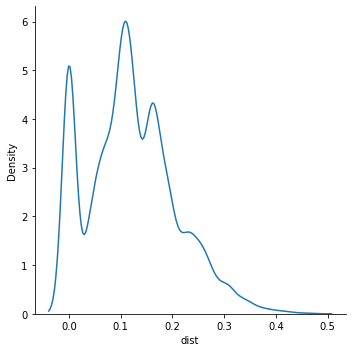

In [13]:
sns.displot(data=df, x='dist', kind='kde')

In [15]:
df.sort_values(by='dist', ascending=False)[['gid', 'n_tss_iq_wtc11','n_ic_iq_wtc11','n_tes_iq_wtc11',
                                            'n_tss_encode_wtc11', 'n_ic_encode_wtc11', 'n_tes_encode_wtc11']]

,gid,n_tss_iq_wtc11,n_ic_iq_wtc11,n_tes_iq_wtc11,n_tss_encode_wtc11,n_ic_encode_wtc11,n_tes_encode_wtc11
2803,ENSG00000110851,1.0,5.0,1.0,1.0,1.0,3.0
9366,ENSG00000177045,1.0,4.0,1.0,5.0,2.0,1.0
129,ENSG00000007866,1.0,6.0,1.0,6.0,5.0,1.0
3632,ENSG00000119711,1.0,2.0,1.0,1.0,1.0,6.0
6823,ENSG00000154511,1.0,3.0,1.0,1.0,1.0,4.0
...,...,...,...,...,...,...,...
1138,ENSG00000082014,2.0,2.0,1.0,2.0,2.0,1.0
4985,ENSG00000134909,1.0,2.0,2.0,1.0,2.0,2.0
1137,ENSG00000081923,1.0,2.0,1.0,1.0,2.0,1.0
7971,ENSG00000165502,1.0,1.0,1.0,1.0,1.0,1.0


In [16]:
df.sort_values(by='dist', ascending=True)[['gid', 'n_tss_iq_wtc11','n_ic_iq_wtc11','n_tes_iq_wtc11',
                                            'n_tss_encode_wtc11', 'n_ic_encode_wtc11', 'n_tes_encode_wtc11']].head()

,gid,n_tss_iq_wtc11,n_ic_iq_wtc11,n_tes_iq_wtc11,n_tss_encode_wtc11,n_ic_encode_wtc11,n_tes_encode_wtc11
5453,ENSG00000138400,1.0,1.0,1.0,1.0,1.0,1.0
11211,ENSG00000213920,1.0,2.0,1.0,1.0,2.0,1.0
6569,ENSG00000151224,1.0,2.0,1.0,1.0,2.0,1.0
4018,ENSG00000124491,1.0,1.0,1.0,1.0,1.0,1.0
4016,ENSG00000124466,2.0,2.0,1.0,2.0,2.0,1.0


## Look at detection and expression of shared ICs

In [74]:
min_tpm = 1
ca = cerberus.read(cerberus_h5)

In [75]:
def get_iq_df_tpm(df, feat, min_tpm, gene_subset):
    dataset_cols = ['wtc11_1_3', 'wtc11_1_2', 'wtc11_1_1']
    df = df[dataset_cols+['annot_transcript_id']]
    if feat != 'triplet':
        df = add_feat(df, col='annot_transcript_id', kind=feat)
        df.drop('annot_transcript_id', inplace=True, axis=1)
        gb_col = feat
    else:
        gb_col = 'annot_transcript_id'
    df = df.groupby(gb_col).sum()
    df = df.loc[(df>=min_tpm).any(axis=1)]
    df.reset_index(inplace=True)
    
    if gene_subset:
        df['gid'] = df.ic.str.split('_', expand=True)[0]
        gene_df, _, _ = get_gtf_info(ver='v40_cerberus', how='gene', add_stable_gid=True)
        df = df.merge(gene_df[['gid_stable', 'biotype_category']], 
                      how='left',
                      left_on='gid',
                      right_on='gid_stable')
        if gene_subset == 'polya':
            gene_subset = get_polya_cats()
        else:
            gene_subset = [gene_subset]
        df = df.loc[df.biotype_category.isin(gene_subset)]
        df.drop(['gid', 'gid_stable', 'biotype_category'], axis=1, inplace=True)
    
    return df

iq_df = pd.read_csv(iq_filt_ab, sep='\t')
iq_df = get_iq_df_tpm(iq_df, 'ic', min_tpm=min_tpm, gene_subset=gene_subset)

tl_df = pd.read_csv(filt_ab, sep='\t')
tl_df, tids = get_tpm_table(tl_df, 
                         how='ic',
                         min_tpm=min_tpm,
                         gene_subset=gene_subset,
                         sample=['wtc11'])

In [76]:
iq_df = pd.read_csv(iq_filt_ab, sep='\t')
iq_df = get_iq_df_tpm(iq_df, 'ic', min_tpm=min_tpm, gene_subset=gene_subset)

In [77]:
tl_df = pd.read_csv(filt_ab, sep='\t')
tl_df, tids = get_tpm_table(tl_df, 
                         how='ic',
                         min_tpm=min_tpm,
                         gene_subset=gene_subset,
                         sample=['wtc11'])

Calculating ic TPM values
Subsetting for ['wtc11'] samples
Subsetting for polya genes
Enforcing minimum TPM
Total # ics detected: 145392
# ics >= 1 tpm: 47564
Applying gene type and novelty subset
Number of ics reported: 47357


In [78]:
# take mean of each library in dataset
tl_df['tl_mean_tpm'] = tl_df.mean(axis=1)
tl_df.reset_index(inplace=True)
tl_df['tl'] = True

iq_df['iq_mean_tpm'] = iq_df.mean(axis=1)
iq_df['iq'] = True
iq_df.reset_index(inplace=True)

df = iq_df.merge(tl_df, how='outer',
                 on='ic', suffixes=('_iq', ''))
df.iq.fillna(False, inplace=True)
df.tl.fillna(False, inplace=True)
df.fillna(0, inplace=True)

df['det_cat'] = df['tl'].astype(str)+'_'+df['iq'].astype(str)

df['tl_log2_avg_tpm'] = np.log2(df.tl_mean_tpm+1)
df['iq_log2_avg_tpm'] = np.log2(df.iq_mean_tpm+1)


df[['iq', 'tl']].reset_index().groupby(['iq', 'tl']).count().reset_index()

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


,iq,tl,index
0,False,True,24736
1,True,False,13495
2,True,True,22621


In [93]:
temp3 = df[['iq', 'tl']].reset_index().groupby(['iq', 'tl']).count().reset_index()
temp3['total'] = temp3['index'].sum(axis=0)
temp3['perc'] = (temp3['index']/temp3['total'])*100
temp3

,iq,tl,index,total,perc
0,False,True,24736,60852,40.649445
1,True,False,13495,60852,22.176757
2,True,True,22621,60852,37.173799


In [94]:
df.head()

,index,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,iq_mean_tpm,iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,tl_mean_tpm,tl,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
0,0.0,ENSG00000000003_1,83.495464,19.932929,20.710954,41.379782,True,116.603488,140.624488,136.354672,131.194216,True,True_True,7.046515,5.405304
1,1.0,ENSG00000000003_2,0.613092,2.300396,0.000000,0.971163,True,0.000000,0.000000,0.000000,0.000000,False,False_True,0.000000,0.979047
2,2.0,ENSG00000000005_3,2.189614,2.300396,4.616112,3.035374,True,0.000000,0.000000,0.000000,0.000000,False,False_True,0.000000,2.012702
3,3.0,ENSG00000000419_1,37.497144,37.956529,25.003938,33.485870,True,13.584872,11.558177,26.081263,17.074771,True,True_True,4.175905,5.107933
4,4.0,ENSG00000000419_16,1.368509,0.000000,1.154028,0.840846,True,0.000000,0.000000,0.000000,0.000000,False,False_True,0.000000,0.880369


In [79]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

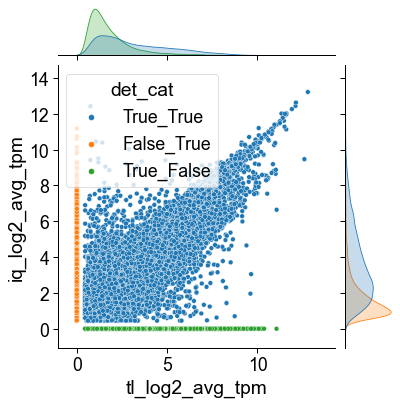

In [80]:
sns.jointplot(df, y='iq_log2_avg_tpm', x='tl_log2_avg_tpm', hue='det_cat')

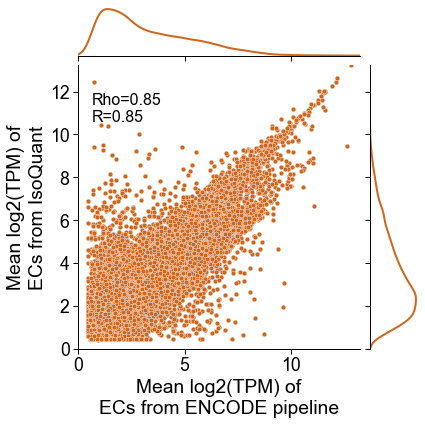

In [91]:
# how well-correlated are the ICs det. in both?
x = 'tl_mean_tpm'
y = 'iq_mean_tpm'
temp = df.loc[df.det_cat=='True_True']
temp = temp[['ic', x, y]].set_index('ic')
rho, p = st.spearmanr(temp[x].tolist(), temp[y].tolist())
r, p2 = st.pearsonr(temp[x].tolist(), temp[y].tolist())

# add pseudocounts and plot log2tpm
temp = temp+1
temp = np.log2(temp)
lim = (0, max(temp[x].max(), temp[y].max()))

c_dict, order= get_biosample_colors(species='human')

g = sns.JointGrid(data=temp, x=x, y=y, ylim=lim, xlim=lim)
g.plot_joint(sns.scatterplot, color=c_dict['wtc11'])
g.plot_marginals(sns.kdeplot, color=c_dict['wtc11'], linewidth=2)

# g.plot_marginals(sns.distplot, kde=True)
# g = sns.jointplot(temp, x=x, y=y, color=c_dict[sample],
#                   ylim=lim, xlim=lim, kind='kde', marginal_kws={'linewidth':2}) 
for d, ax in zip([x,y], ['x','y']):
    label = 'WTC11'
    label += f" Rep. {'_'.join(d.rsplit('_',2)[-2:])}"
    if ax == 'x':
        g.ax_joint.set_xlabel('Mean log2(TPM) of\nECs from ENCODE pipeline')
    elif ax == 'y':
        g.ax_joint.set_ylabel('Mean log2(TPM) of\nECs from IsoQuant')
plt.text(.05, .8, 'Rho={:.2f}\nR={:.2f}'.format(rho,r), transform=g.ax_joint.transAxes,
          size=16)

# fname = 'figures/shared_ec_wtc11_iq_v_cerb_corr.pdf'
fname = 'figures/shared_ec_wtc11_iq_v_cerb_corr.png'

plt.savefig(fname, dpi=500)

In [100]:
# det of genes
x = 'tl_mean_tpm'
y = 'iq_mean_tpm'
temp = df.copy(deep=True)
temp['gid'] = temp['ic'].str.split('_', expand=True)[0] 
temp = temp[[x,y,'det_cat', 'gid']]
temp = temp.groupby(['gid', 'det_cat']).sum().reset_index()
temp3 = temp[['det_cat', 'gid']].reset_index().groupby(['det_cat']).count().reset_index()
temp3['total'] = temp3['gid'].sum(axis=0)
temp3['perc'] = (temp3['gid']/temp3['total'])*100
temp3

,det_cat,index,gid,total,perc
0,False_True,7687,7687,28611,26.867289
1,True_False,9185,9185,28611,32.103037
2,True_True,11739,11739,28611,41.029674


In [102]:
temp.loc[temp.det_cat=='False_True'].head()

,gid,det_cat,tl_mean_tpm,iq_mean_tpm
0,ENSG00000000003,False_True,0.0,0.971163
3,ENSG00000000005,False_True,0.0,3.035374
4,ENSG00000000419,False_True,0.0,0.840846
7,ENSG00000000457,False_True,0.0,1.400129
9,ENSG00000000460,False_True,0.0,10.271909


In [103]:
temp.loc[temp.det_cat=='True_False'].head()

,gid,det_cat,tl_mean_tpm,iq_mean_tpm
1,ENSG00000000003,True_False,15.240610,0.0
5,ENSG00000000419,True_False,2.608764,0.0
10,ENSG00000000460,True_False,26.491408,0.0
12,ENSG00000001036,True_False,3.748732,0.0
15,ENSG00000001084,True_False,0.871080,0.0


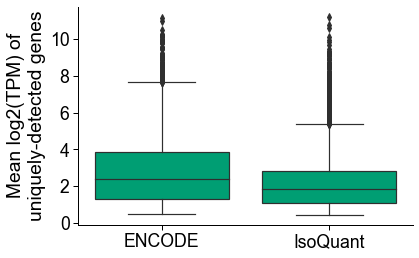

In [121]:
## How highly-expressed are genes for the different detection categories?
uniq_df = temp.loc[temp.det_cat.str.contains('False')]
uniq_df.head()
uniq_df['det'] = False
uniq_df.loc[uniq_df.det_cat=='True_False', 'det'] = 'ENCODE'
uniq_df.loc[uniq_df.det_cat=='False_True', 'det'] = 'IsoQuant'
uniq_df.drop('det_cat', axis=1, inplace=True)
uniq_df = uniq_df.melt(id_vars=['det', 'gid'])
uniq_df = uniq_df.loc[uniq_df.value>0] # get rid of things that aren't expressed
uniq_df.rename({'value': 'mean_tpm'}, axis=1, inplace=True)
uniq_df['mean_tpm_pseudo'] = uniq_df['mean_tpm']+1
uniq_df['mean_log2tpm'] = np.log2(uniq_df.mean_tpm_pseudo)
uniq_df
temp_c_dict, order = get_ic_nov_colors()
c = temp_c_dict['Known']
ax = sns.boxplot(data=uniq_df, y='mean_log2tpm', x='det', color=c, saturation=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(xlabel='', ylabel='Mean log2(TPM) of\nuniquely-detected genes')

fname = 'figures/iq_v_cerb_uniq_gene_tpms.pdf'
plt.savefig(fname, dpi=500)

In [119]:
x = uniq_df.loc[uniq_df.det=='ENCODE', 'mean_log2tpm'].tolist()
y = uniq_df.loc[uniq_df.det=='IsoQuant', 'mean_log2tpm'].tolist()
st.mannwhitneyu(x,y)

MannwhitneyuResult(statistic=42381237.0, pvalue=8.868664844354995e-112)

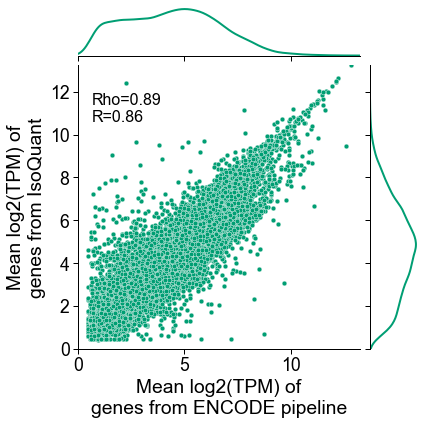

In [90]:
# how well-correlated are the known polyA genes det. in both?
x = 'tl_mean_tpm'
y = 'iq_mean_tpm'
temp = df.copy(deep=True)
temp['gid'] = temp['ic'].str.split('_', expand=True)[0] 
temp = temp[[x,y,'gid']]
temp = temp.groupby('gid').sum().reset_index()
temp = temp.loc[df.det_cat=='True_True']


temp = temp[['gid', x, y]].set_index('gid')
rho, p = st.spearmanr(temp[x].tolist(), temp[y].tolist())
r, p2 = st.pearsonr(temp[x].tolist(), temp[y].tolist())

# add pseudocounts and plot log2tpm
temp = temp+1
temp = np.log2(temp)
lim = (0, max(temp[x].max(), temp[y].max()))

ic_colors, order = get_ic_nov_colors()
c = ic_colors['Known']

g = sns.JointGrid(data=temp, x=x, y=y, ylim=lim, xlim=lim)
g.plot_joint(sns.scatterplot, color=c)
g.plot_marginals(sns.kdeplot, color=c, linewidth=2)

# g.plot_marginals(sns.distplot, kde=True)
# g = sns.jointplot(temp, x=x, y=y, color=c_dict[sample],
#                   ylim=lim, xlim=lim, kind='kde', marginal_kws={'linewidth':2}) 
for d, ax in zip([x,y], ['x','y']):
    label = 'WTC11'
    label += f" Rep. {'_'.join(d.rsplit('_',2)[-2:])}"
    if ax == 'x':
        g.ax_joint.set_xlabel('Mean log2(TPM) of\ngenes from ENCODE pipeline')
    elif ax == 'y':
        g.ax_joint.set_ylabel('Mean log2(TPM) of\ngenes from IsoQuant')
plt.text(.05, .8, 'Rho={:.2f}\nR={:.2f}'.format(rho,r), transform=g.ax_joint.transAxes,
          size=16)

# fname = 'figures/shared_gene_wtc11_iq_v_cerb_corr.pdf'
fname = 'figures/shared_gene_wtc11_iq_v_cerb_corr.png'

plt.savefig(fname, dpi=500)

In [87]:
temp

,gid,tl_mean_tpm,iq_mean_tpm
0,ENSG00000000003,131.194216,41.379782
1,ENSG00000000419,19.262252,39.168241
2,ENSG00000000457,5.506909,1.351258
3,ENSG00000001036,110.294276,18.466180
4,ENSG00000001084,63.588303,37.898286
...,...,...,...
11734,ENSG00000285756,7.975523,12.242174
11735,ENSG00000285793,55.513959,71.026707
11736,ENSG00000285816,3.194941,3.802172
11737,ENSG00000285967,3.512004,4.804533


In [64]:
df = df.merge(ca.ic[['Name', 'novelty']], how='left', left_on='ic', right_on='Name')

In [67]:
def plot_ic_novelty_per_det_cat(df,
                    ofile,
                    novs=None,
                    ylim=None):
    """
    Plot number of intron chains per novelty category.

    Parameters:
        fname (str): Cerberus annotation file name
        oprefix (str): Place to save
        ylim (int): y limit of resultant plot
        pass_list (list of str): List of ic IDs to retain
        save_type (str): Choose from 'pdf' or 'png'
    """

    sns.set_context('paper', font_scale=1.6)

    temp = df.copy(deep=True)

    temp = temp[['Name', 'novelty', 'det_hr']]
    temp = temp.groupby(['novelty', 'det_hr']).count()
    temp.reset_index(inplace=True)
    
    if not novs:
        novs = temp.novelty.unique().tolist()
    else:
        temp = temp.loc[temp.novelty.isin(novs)]

    temp.rename({'Name': 'counts'}, axis=1, inplace=True)
    print(temp)
    c_dict, order = get_ic_nov_colors(cats=novs)

    temp = temp.loc[temp.novelty.isin(novs)].copy(deep=True)
    complete = temp[['counts']].sum(axis=0)
    print('Number of complete intron chains: {}'.format(complete))

    # actual plotting
    sns.set_context('paper', font_scale=2)
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['pdf.fonttype'] = 42
    # plt.figure(figsize=(4,6))
    plt.figure(figsize=(5,4))
    
    c_dict, order = get_ic_nov_colors(cats=novs)
    temp['novelty'] = temp['novelty'].astype(str).astype('category')
    temp['novelty'] = temp['novelty'].cat.reorder_categories(order, ordered=True)
    cats = ['ENCODE + IsoQuant', 'ENCODE only', 'IsoQuant only']
    temp['det_hr'] = temp['det_hr'].astype('category')
    temp['det_hr'] = temp['det_hr'].cat.reorder_categories(cats, ordered=True)

    # g = sns.catplot(data=temp, x='novelty',
    #             y='counts', kind='bar',
    #             saturation=1,
    #             hue='det_hr',
    #             # hue_order=cats,
    #             palette=c_dict,
    #             order=order)
    g = sns.barplot(data=temp,
            x='novelty',
            y='counts',
            hue='det_hr',
            order=order,
            hue_order=cats,
            saturation=1)
    g.spines['right'].set_visible(False)
    g.spines['top'].set_visible(False)
    g.set(ylabel='# WTC11 ECs', xlabel='')
    g.tick_params(axis="x", rotation=45)
    

    
    for bar_group, cat in zip(g.containers, cats):
        for bar, cat2 in zip(bar_group, order):
            c = c_dict[cat2]
            c_dict_2, order_2 = get_shade_colors(c, cats)
            bar.set_facecolor(c_dict_2[cat])

    # add percentage labels
    # ax = g.axes[0,0]
    # add_perc(ax, temp, 'counts')

    if ylim:
        g.set(ylim=(0,ylim))

    # save figure
    plt.savefig(ofile, dpi=500, bbox_inches='tight')

    plt.show()
    plt.clf()

   novelty             det_hr  counts
0      ISM  ENCODE + IsoQuant     720
1      ISM        ENCODE only    2291
2      ISM      IsoQuant only     265
3    Known  ENCODE + IsoQuant   16838
4    Known        ENCODE only   11026
5    Known      IsoQuant only    4608
6      NIC  ENCODE + IsoQuant    3989
7      NIC        ENCODE only    6984
8      NIC      IsoQuant only    1047
9      NNC  ENCODE + IsoQuant    1074
10     NNC        ENCODE only    4435
11     NNC      IsoQuant only     171
Number of complete intron chains: counts    53448
dtype: int64


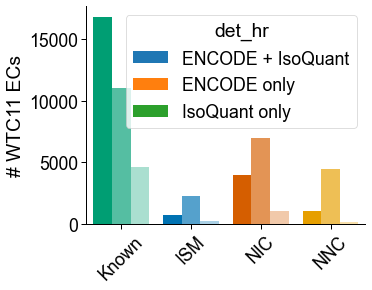

<Figure size 432x288 with 0 Axes>

In [73]:
# How many intersect per novelty category?
det_map = {'True_False': 'ENCODE only',
           'True_True': 'ENCODE + IsoQuant',
           'False_True': 'IsoQuant only'}
df['det_hr'] = df.det_cat.map(det_map)
temp = plot_ic_novelty_per_det_cat(df,
                            'figures/wtc11_iq_encode_det_per_nov.pdf',
                            novs=['Known', 'ISM', 'NIC', 'NNC'])

## First figure out which transcripts are expressed using the same criteria as we do for the TALON+LAPA data

* Does that actually make sense tho? Probably not...

In [4]:
def get_iq_df_tpm(df, feat):
    dataset_cols = ['wtc11_1_3', 'wtc11_1_2', 'wtc11_1_1']
    df = df[dataset_cols+['annot_transcript_id']]
    if feat != 'triplet':
        df = add_feat(df, col='annot_transcript_id', kind=feat)
        df.drop('annot_transcript_id', inplace=True, axis=1)
        gb_col = feat
    else:
        gb_col = 'annot_transcript_id'
    df = df.groupby(gb_col).sum().reset_index()
    
    return df


In [5]:
iq_df = pd.read_csv(iq_filt_ab, sep='\t')
iq_df = get_iq_df_tpm(iq_df, 'triplet')

tl_df = pd.read_csv(filt_ab, sep='\t')
tl_df, tids = get_tpm_table(tl_df, 
                         how='iso',
                         min_tpm=1,
                         gene_subset=None,
                         sample=['wtc11'])

tl_df.reset_index(inplace=True)

df = iq_df.merge(tl_df, how='outer',
                 on='annot_transcript_id', suffixes=('_iq', ''))
df['iq_det'] = ~df.wtc11_1_1_iq.isna()
df['tl_det'] = ~df.wtc11_1_1.isna()
df = df[['annot_transcript_id', 'iq_det', 'tl_det']]
df.groupby(['iq_det', 'tl_det']).count()
df.head()


Calculating iso TPM values
Subsetting for ['wtc11'] samples
Enforcing minimum TPM
Total # isos detected: 236615
# isos >= 1 tpm: 64107
Number of isos reported: 64107


,annot_transcript_id,iq_det,tl_det
0,"ENSG00000000003[1,1,5]",True,True
1,"ENSG00000000003[2,2,1]",True,False
2,"ENSG00000000005[2,3,1]",True,False
3,"ENSG00000000419[1,1,1]",True,True
4,"ENSG00000000419[1,16,1]",True,False


In [6]:
min_tpm = 0
iq_df = pd.read_csv(iq_filt_ab, sep='\t')
iq_df = get_iq_df_tpm(iq_df, 'ic')

tl_df = pd.read_csv(filt_ab, sep='\t')
# tl_df = pd.read_csv(unfilt_ab, sep='\t')
tl_df, tids = get_tpm_table(tl_df, 
                         how='ic',
                         min_tpm=min_tpm,
                         gene_subset=None,
                         sample=['wtc11'])

tl_df.reset_index(inplace=True)

df = iq_df.merge(tl_df, how='outer',
                 on='ic', suffixes=('_iq', ''))
df.fillna(0, inplace=True)
# df['iq_det'] = ~df.wtc11_1_1_iq.isna()
# df['tl_det'] = ~df.wtc11_1_1.isna()
iq_cols = ['wtc11_1_1_iq', 'wtc11_1_2_iq', 'wtc11_1_3_iq']
df['iq_det'] = df[iq_cols].sum(axis=1) != 0
df['iq_avg_tpm'] = df[iq_cols].mean(axis=1)
tl_cols = ['wtc11_1_1', 'wtc11_1_2', 'wtc11_1_3']
df['tl_det'] = df[tl_cols].sum(axis=1) != 0
df['tl_avg_tpm'] = df[tl_cols].mean(axis=1)
df['det_cat'] = df['iq_det'].astype(str)+'_'+df['tl_det'].astype(str)
df = df.loc[df.det_cat != 'False_False']

df['tl_log2_avg_tpm'] = np.log2(df.tl_avg_tpm+1)
df['iq_log2_avg_tpm'] = np.log2(df.iq_avg_tpm+1)

print(df.loc[df.ic.str.contains('ENSG00000000003')])


temp = df[['ic', 'iq_det', 'tl_det']]
temp = temp.groupby(['iq_det', 'tl_det']).count().reset_index()
print(temp)


Calculating ic TPM values
Subsetting for ['wtc11'] samples
Number of ics reported: 145392
                       ic  wtc11_1_3_iq  wtc11_1_2_iq  wtc11_1_1_iq  \
0       ENSG00000000003_1     83.495464     19.932929     20.710954   
1       ENSG00000000003_2      0.613092      2.300396      0.000000   
38176  ENSG00000000003_10      0.000000      0.000000      0.000000   
38177  ENSG00000000003_11      0.000000      0.000000      0.000000   
38178  ENSG00000000003_12      0.000000      0.000000      0.000000   
38180   ENSG00000000003_6      0.000000      0.000000      0.000000   
38181   ENSG00000000003_7      0.000000      0.000000      0.000000   
38182   ENSG00000000003_8      0.000000      0.000000      0.000000   
38183   ENSG00000000003_9      0.000000      0.000000      0.000000   

        wtc11_1_1   wtc11_1_2   wtc11_1_3  iq_det  iq_avg_tpm  tl_det  \
0      116.603488  140.624488  136.354672    True   41.379782    True   
1        0.000000    0.000000    0.000000    True    

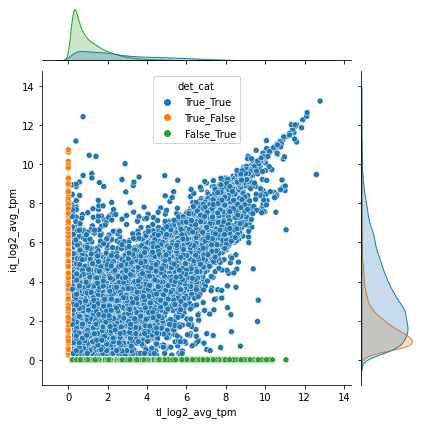

In [7]:
df.loc[df.ic.str.contains('ENSG00000000003')]
sns.jointplot(df, y='iq_log2_avg_tpm', x='tl_log2_avg_tpm', hue='det_cat')

In [16]:
# temp2 = df.loc[(df.det_cat=='True_False')|(df.det_cat=='False_True')]
# temp2['det_log2_avg_tpm'] = temp2[['iq_log2_avg_tpm', 'tl_log2_avg_tpm']].max(axis=1)
# temp2.head()
# sns.catplot(temp2, y='det_log2_avg_tpm', x='det_cat', kind='violin')

In [9]:
# df.loc[(df.iq_det==True)&(df.tl_det==False)].head()

In [8]:
df.loc[(df.det_cat=='False_True')&(df.tl_log2_avg_tpm<2)]

,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,iq_det,iq_avg_tpm,tl_det,tl_avg_tpm,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
38177,ENSG00000000003_11,0.0,0.0,0.0,1.132073,0.000000,1.372698,False,0.0,True,0.834924,False_True,0.875720,0.0
38178,ENSG00000000003_12,0.0,0.0,0.0,0.000000,1.926363,0.000000,False,0.0,True,0.642121,False_True,0.715560,0.0
38180,ENSG00000000003_6,0.0,0.0,0.0,0.566036,0.963181,0.457566,False,0.0,True,0.662261,False_True,0.733147,0.0
38182,ENSG00000000003_8,0.0,0.0,0.0,0.566036,0.000000,0.000000,False,0.0,True,0.188679,False_True,0.249359,0.0
38183,ENSG00000000003_9,0.0,0.0,0.0,2.264145,0.963181,2.287830,False,0.0,True,1.838386,False_True,1.505071,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155235,TALONG000186746_1,0.0,0.0,0.0,0.566036,0.000000,0.457566,False,0.0,True,0.341201,False_True,0.423525,0.0
155236,TALONG000187635_1,0.0,0.0,0.0,0.000000,2.889544,2.287830,False,0.0,True,1.725791,False_True,1.446675,0.0
155237,TALONG000189031_1,0.0,0.0,0.0,1.698109,0.000000,0.000000,False,0.0,True,0.566036,False_True,0.647118,0.0
155241,TALONG000195728_1,0.0,0.0,0.0,0.000000,1.926363,2.745396,False,0.0,True,1.557253,False_True,1.354595,0.0


In [18]:
df.loc[(df.det_cat=='True_False')&(df.iq_log2_avg_tpm<2)]

,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,iq_det,iq_avg_tpm,tl_det,tl_avg_tpm,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
1,ENSG00000000003_2,0.614607,2.291045,0.000000,0.0,0.0,0.0,True,0.968551,False,0.0,True_False,0.0,0.977134
8,ENSG00000000457_10,0.181090,1.145523,0.768900,0.0,0.0,0.0,True,0.698504,False,0.0,True_False,0.0,0.764265
10,ENSG00000000457_9,0.729846,0.000000,0.768900,0.0,0.0,0.0,True,0.499582,False,0.0,True_False,0.0,0.584560
11,ENSG00000000460_1,0.773746,2.291045,0.768900,0.0,0.0,0.0,True,1.277897,False,0.0,True_False,0.0,1.187703
14,ENSG00000000460_16,0.224990,2.291045,1.537799,0.0,0.0,0.0,True,1.351278,False,0.0,True_False,0.0,1.233445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37863,ENSG00000285825_4,1.646269,0.000000,0.768900,0.0,0.0,0.0,True,0.805056,False,0.0,True_False,0.0,0.852044
37866,ENSG00000285897_2,0.548756,0.000000,0.768900,0.0,0.0,0.0,True,0.439219,False,0.0,True_False,0.0,0.525286
37868,ENSG00000285942_2,0.548756,1.145523,0.768900,0.0,0.0,0.0,True,0.821060,False,0.0,True_False,0.0,0.864778
37872,ENSG00000285982_2,1.097513,0.572761,1.922249,0.0,0.0,0.0,True,1.197508,False,0.0,True_False,0.0,1.135868


In [9]:
df.loc[(df.det_cat=='False_True')&(df.tl_log2_avg_tpm>10)]

,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,iq_det,iq_avg_tpm,tl_det,tl_avg_tpm,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
66277,ENSG00000115053_1,0.0,0.0,0.0,1278.110073,1031.567308,1240.003898,False,0.0,True,1183.227093,False_True,10.209730,0.0
78252,ENSG00000132341_1,0.0,0.0,0.0,934.526010,1392.760343,1225.819352,False,0.0,True,1184.368568,False_True,10.211120,0.0
94128,ENSG00000150753_1,0.0,0.0,0.0,953.771245,1096.100464,1021.287344,False,0.0,True,1023.719684,False_True,10.001014,0.0
105089,ENSG00000165280_1,0.0,0.0,0.0,1256.034655,883.237368,1077.567963,False,0.0,True,1072.279996,False_True,10.067811,0.0
112859,ENSG00000172270_34,0.0,0.0,0.0,1079.997351,1661.487961,1210.719674,False,0.0,True,1317.401662,False_True,10.364574,0.0
118865,ENSG00000181163_1,0.0,0.0,0.0,1608.109263,2542.798967,2218.280037,False,0.0,True,2123.062756,False_True,11.052611,0.0


In [10]:
df.loc[(df.det_cat=='True_False')&(df.iq_log2_avg_tpm>10)]

,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,iq_det,iq_avg_tpm,tl_det,tl_avg_tpm,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
7227,ENSG00000105372_4,443.396879,3144.870962,1126.331252,0.0,0.0,0.0,True,1571.533031,False,0.0,True_False,0.0,10.618875
22438,ENSG00000161203_1,1008.426829,1204.556201,1162.498487,0.0,0.0,0.0,True,1125.160506,False,0.0,True_False,0.0,10.137197
27126,ENSG00000172270_6,1483.567640,2083.617911,1564.638750,0.0,0.0,0.0,True,1710.608100,False,0.0,True_False,0.0,10.741137


In [11]:
df.loc[(df.det_cat=='True_False')&(df.iq_log2_avg_tpm>10)]

,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,iq_det,iq_avg_tpm,tl_det,tl_avg_tpm,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
7199,ENSG00000105372_4,440.212345,3122.981088,1121.055571,0.0,0.0,0.0,True,1561.416335,False,0.0,True_False,0.0,10.609563
26941,ENSG00000172270_6,1601.205183,2256.301572,1703.781487,0.0,0.0,0.0,True,1853.762747,False,0.0,True_False,0.0,10.857019
27088,ENSG00000172757_2,1144.546610,1535.000333,1091.837388,0.0,0.0,0.0,True,1257.128110,False,0.0,True_False,0.0,10.297063
37605,ENSG00000277957_1,797.902710,2026.429544,1634.680483,0.0,0.0,0.0,True,1486.337579,False,0.0,True_False,0.0,10.538516


In [13]:
g = 'ENSG00000172270'
df.loc[(df.ic.str.contains(g))]

,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,iq_det,iq_avg_tpm,tl_det,tl_avg_tpm,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
26937,ENSG00000172270_1,2.129175,5.349591,0.668943,0.000000,0.000000,0.000000,True,2.715903,False,0.000000,True_False,0.000000,1.893713
26938,ENSG00000172270_10,1.218239,4.593546,1.437842,0.000000,0.000000,0.000000,True,2.416542,False,0.000000,True_False,0.000000,1.772537
26939,ENSG00000172270_2,8.714251,8.786159,6.820139,0.000000,0.000000,0.000000,True,8.106850,False,0.000000,True_False,0.000000,3.186952
26940,ENSG00000172270_34,1615.785639,2280.208629,1710.893808,1079.997351,1661.487961,1210.719674,True,1868.962692,True,1317.401662,True_True,10.364574,10.868794
26941,ENSG00000172270_6,1601.205183,2256.301572,1703.781487,0.000000,0.000000,0.000000,True,1853.762747,False,0.000000,True_False,0.000000,10.857019
112351,ENSG00000172270_28,0.000000,0.000000,0.000000,3.962254,3.852726,5.490792,False,0.000000,True,4.435257,False_True,2.442348,0.000000
112352,ENSG00000172270_29,0.000000,0.000000,0.000000,3.396218,0.000000,0.915132,False,0.000000,True,1.437117,False_True,1.285175,0.000000
112353,ENSG00000172270_30,0.000000,0.000000,0.000000,0.000000,0.963181,0.000000,False,0.000000,True,0.321060,False_True,0.401697,0.000000
112354,ENSG00000172270_31,0.000000,0.000000,0.000000,1.132073,0.963181,0.000000,False,0.000000,True,0.698418,False_True,0.764192,0.000000
112356,ENSG00000172270_33,0.000000,0.000000,0.000000,78.113016,92.465417,88.767807,False,0.000000,True,86.448747,False_True,6.450366,0.000000


In [12]:
g = 'ENSG00000277957'
g2 = 'ENSG00000161960'

df.loc[(df.ic.str.contains(g))|(df.ic.str.contains(g2))]

,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,iq_det,iq_avg_tpm,tl_det,tl_avg_tpm,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
22432,ENSG00000161960_1,1784.780645,1140.940546,1046.472313,1749.618350,2310.672243,2000.936180,True,1324.064501,True,2020.408924,True_True,10.981145,10.371847
22433,ENSG00000161960_2,1.865772,1.145523,6.151197,0.000000,0.000000,0.000000,True,3.054164,False,0.000000,True_False,0.000000,2.019404
22434,ENSG00000161960_3,1.865772,0.000000,2.306699,5.094327,1.926363,2.745396,True,1.390824,True,3.255362,True_True,2.089282,1.257508
37605,ENSG00000277957_1,797.902710,2026.429544,1634.680483,0.000000,0.000000,0.000000,True,1486.337579,False,0.000000,True_False,0.000000,10.538516
100486,ENSG00000161960_32,0.000000,0.000000,0.000000,0.566036,0.000000,0.000000,False,0.000000,True,0.188679,False_True,0.249359,0.000000
100490,ENSG00000161960_38,0.000000,0.000000,0.000000,0.566036,2.889544,1.372698,False,0.000000,True,1.609426,False_True,1.383733,0.000000
100491,ENSG00000161960_39,0.000000,0.000000,0.000000,1.132073,0.963181,1.830264,False,0.000000,True,1.308506,False_True,1.206960,0.000000
100492,ENSG00000161960_4,0.000000,0.000000,0.000000,0.566036,0.963181,0.457566,False,0.000000,True,0.662261,False_True,0.733147,0.000000
100493,ENSG00000161960_40,0.000000,0.000000,0.000000,4.528291,5.779089,3.660528,False,0.000000,True,4.655969,False_True,2.499774,0.000000
100495,ENSG00000161960_42,0.000000,0.000000,0.000000,1.132073,0.000000,0.915132,False,0.000000,True,0.682402,False_True,0.750522,0.000000


In [21]:
g = 'ENSG00000277957'
g2 = 'ENSG00000161960'
ca.ic.loc[(ca.ic.gene_id==g)|(ca.ic.gene_id==g2)].head()
ca.ic.loc[(ca.ic.Name.isin(['ENSG00000277957_1', 'ENSG00000277957_2']))].head()

,Chromosome,Strand,Coordinates,Name,source,novelty,id,gene_id,ic
96745,chr17,+,7563791-7564624-7564864-7564958-7565070-756543...,ENSG00000277957_1,"v40,v29,isoquant_wtc11",Known,96745.0,ENSG00000277957,1
271251,chr17,+,7562263-7563065-7563791-7564624-7564864-756495...,ENSG00000277957_2,lapa,NNC,271251.0,ENSG00000277957,2


In [14]:
df.loc[df.ic.str.contains('ENSG00000172757')]

,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,iq_det,iq_avg_tpm,tl_det,tl_avg_tpm,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
27086,ENSG00000172757_1,1201.452644,1572.802580,1119.517772,784.803847,1253.831687,1010.175245,True,1297.924332,True,1016.270259,True_True,9.990487,10.343102
27087,ENSG00000172757_13,1.481642,1.145523,0.768900,0.565014,0.961527,1.369420,True,1.132022,True,0.965320,True_True,0.974764,1.092222
27088,ENSG00000172757_2,1144.546610,1535.000333,1091.837388,0.000000,0.000000,0.000000,True,1257.128110,False,0.000000,True_False,0.000000,10.297063
116108,ENSG00000172757_10,0.000000,0.000000,0.000000,16.385393,27.884294,16.433036,False,0.000000,True,20.234241,False_True,4.408321,0.000000
116110,ENSG00000172757_3,0.000000,0.000000,0.000000,0.565014,1.923055,0.912946,False,0.000000,True,1.133672,False_True,1.093338,0.000000
116111,ENSG00000172757_4,0.000000,0.000000,0.000000,0.565014,1.923055,1.369420,False,0.000000,True,1.285829,False_True,1.192718,0.000000
116112,ENSG00000172757_5,0.000000,0.000000,0.000000,3.390081,0.000000,2.282366,False,0.000000,True,1.890816,False_True,1.531477,0.000000
116114,ENSG00000172757_7,0.000000,0.000000,0.000000,0.000000,0.000000,0.912946,False,0.000000,True,0.304315,False_True,0.383293,0.000000
116116,ENSG00000172757_9,0.000000,0.000000,0.000000,0.565014,0.000000,0.000000,False,0.000000,True,0.188338,False_True,0.248945,0.000000


In [15]:
df.loc[df.ic.str.contains('ENSG00000172270')]

,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,iq_det,iq_avg_tpm,tl_det,tl_avg_tpm,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
26937,ENSG00000172270_1,2.129175,5.349591,0.668943,0.000000,0.000000,0.000000,True,2.715903,False,0.000000,True_False,0.000000,1.893713
26938,ENSG00000172270_10,1.218239,4.593546,1.437842,0.000000,0.000000,0.000000,True,2.416542,False,0.000000,True_False,0.000000,1.772537
26939,ENSG00000172270_2,8.714251,8.786159,6.820139,0.000000,0.000000,0.000000,True,8.106850,False,0.000000,True_False,0.000000,3.186952
26940,ENSG00000172270_34,1615.785639,2280.208629,1710.893808,1078.045889,1658.634708,1207.828151,True,1868.962692,True,1314.836249,True_True,10.361764,10.868794
26941,ENSG00000172270_6,1601.205183,2256.301572,1703.781487,0.000000,0.000000,0.000000,True,1853.762747,False,0.000000,True_False,0.000000,10.857019
115698,ENSG00000172270_28,0.000000,0.000000,0.000000,3.955095,3.846109,5.477679,False,0.000000,True,4.426294,False_True,2.439967,0.000000
115699,ENSG00000172270_29,0.000000,0.000000,0.000000,3.390081,0.000000,0.912946,False,0.000000,True,1.434343,False_True,1.283532,0.000000
115700,ENSG00000172270_30,0.000000,0.000000,0.000000,0.000000,0.961527,0.000000,False,0.000000,True,0.320509,False_True,0.401094,0.000000
115701,ENSG00000172270_31,0.000000,0.000000,0.000000,1.130027,0.961527,0.000000,False,0.000000,True,0.697185,False_True,0.763144,0.000000
115703,ENSG00000172270_33,0.000000,0.000000,0.000000,77.971872,92.306627,88.555805,False,0.000000,True,86.278102,False_True,6.447548,0.000000


In [7]:
ca = cerberus.read(iq_cerberus_h5)

In [8]:
ca.ic.loc[(ca.ic.gene_id=='ENSG00000172270')].Coordinates.tolist()

['571579-579499-579656-580378-580461-580645-580782-581314-581591-582305-582330-582513-582582-582749',
 '571579-580378-580461-580645-580782-581314-581591-582305-582330-582513-582582-582749',
 '572701-577773',
 '572701-577773-578121-579499-579656-580378-580461-580645-580782-581314-581591-582305-582330-582513-582582-582749',
 '572701-579499-579579-582519-582582-582749',
 '572701-579499-579656-580378-580461-580645-580782-581314-581591-582305-582330-582513-582578-582749',
 '572701-579499-579656-580378-580461-580645-580782-581314-581591-582305-582330-582513-582582-582749',
 '572701-579499-579656-580378-580461-580645-580782-581314-581591-582305-582330-582517-582582-582749',
 '572701-579499-579656-580378-580461-580645-580782-581314-581591-582305-582330-582522-582582-582749',
 '572701-579499-579656-580378-580461-580655-580782-581314-581591-582305-582330-582513-582582-582749',
 '572701-579499-579656-580378-580782-581314',
 '572701-579499-580461-580645-580782-581314-581591-582305-582330-582513-58

In [131]:
ic_names = ['ENSG00000172270_6', 'ENSG00000172270_34', 'ENSG00000172270_33']
ca.ic.loc[(ca.ic.Name.isin(ic_names))].Coordinates.tolist()

['572701-579499-579656-580378-580461-580645-580782-581314-581591-582305-582330-582513-582582-582749',
 '572701-579499-579656-580378-580461-580645-580782-581314-581610-582513-582578-582749',
 '572701-579499-579656-580378-580461-580645-580782-581314-581610-582513-582582-582749']

In [122]:
ca.ic.loc[(ca.ic.Name=='ENSG00000105372_4')|(ca.ic.Name=='ENSG00000105372_1')]

,Chromosome,Strand,Coordinates,Name,source,novelty,id,gene_id,ic
114129,chr19,+,41860289-41860774-41860845-41861111-41861212-4...,ENSG00000105372_1,"v40,v29,lapa,gtex,isoquant_wtc11",Known,114129.0,ENSG00000105372,1
114131,chr19,+,41860289-41860784-41860845-41861111-41861212-4...,ENSG00000105372_4,"v40,v29,lapa,isoquant_wtc11",Known,114131.0,ENSG00000105372,4


In [91]:
ca.ic.loc[ca.ic.Name=='ENSG00000000003_11']

,Chromosome,Strand,Coordinates,Name,source,novelty,id,gene_id,ic
300536,chrX,-,100636607-100635746-100635557-100635252-100635...,ENSG00000000003_11,lapa,ISM,300536.0,ENSG00000000003,11


In [71]:
ca.ic.loc[ca.ic.Name=='ENSG00000000003_10']

,Chromosome,Strand,Coordinates,Name,source,novelty,id,gene_id,ic
300535,chrX,-,100636607-100635746-100635557-100635252-100635...,ENSG00000000003_10,lapa,NIC,300535.0,ENSG00000000003,10


In [73]:
ca.ic.loc[ca.ic.source.str.contains('isoquant')].head()

,Chromosome,Strand,Coordinates,Name,source,novelty,id,gene_id,ic
0,chr1,+,-,ENSG00000004487_18,"v40,v29,lapa,isoquant_wtc11",Known,0.0,ENSG00000004487,18
25,chr1,+,-,ENSG00000162783_1,"v40,v29,lapa,isoquant_wtc11",Known,25.0,ENSG00000162783,1
31,chr1,+,-,ENSG00000175793_1,"v40,v29,lapa,isoquant_wtc11",Known,31.0,ENSG00000175793,1
32,chr1,+,-,ENSG00000176022_1,"v40,v29,lapa,isoquant_wtc11",Known,32.0,ENSG00000176022,1
43,chr1,+,-,ENSG00000179023_1,"v40,v29,lapa,gtex,isoquant_wtc11",Known,43.0,ENSG00000179023,1


In [75]:
ca.t_map.loc[ca.t_map.source=='isoquant'].head()

,original_transcript_id,ic,ic_id,tss_id,tss,tes_id,tes,gene_id,gene_name,original_transcript_name,transcript_triplet,transcript_id,transcript_name,tss_first_sd_issue,tes_last_sa_issue,source


In [134]:
# what do highly-expressed ICs in TL but not in IQ look like? 
df.loc[(df.det_cat=='False_True')&(df.tl_log2_avg_tpm>10)]

,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,iq_det,iq_avg_tpm,tl_det,tl_avg_tpm,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
67106,ENSG00000115053_1,0.0,0.0,0.0,1275.800638,1029.795810,1237.042437,False,0.0,True,1180.879628,False_True,10.206867,0.0
79626,ENSG00000132341_1,0.0,0.0,0.0,932.837402,1390.368573,1222.891767,False,0.0,True,1182.032581,False_True,10.208274,0.0
107670,ENSG00000165280_1,0.0,0.0,0.0,1253.765109,881.720596,1074.994442,False,0.0,True,1070.160049,False_True,10.064958,0.0
115728,ENSG00000172270_34,0.0,0.0,0.0,1078.045889,1658.634708,1207.828151,False,0.0,True,1314.836249,False_True,10.361764,0.0
121956,ENSG00000181163_1,0.0,0.0,0.0,1605.203549,2538.432249,2212.982190,False,0.0,True,2118.872663,False_True,11.049762,0.0
124000,ENSG00000184009_1,0.0,0.0,0.0,3022.257580,3180.732530,3054.262342,False,0.0,True,3085.750817,False_True,11.591873,0.0


In [138]:
ic_names = ['ENSG00000184009_29', 'ENSG00000184009_5', 'ENSG00000184009_1']
ca.ic.loc[(ca.ic.Name.isin(ic_names))].Coordinates.tolist()

['81512605-81512360-81512231-81512142-81511902-81511626-81511187-81511108-81510926-81510833',
 '81512733-81512360-81512231-81512142-81511902-81511626-81511187-81511108-81510926-81510833',
 '81512733-81512360-81512231-81512142-81511902-81511626-81511187-81511108-81510926-81510833-81510479-81510329']

In [137]:
g = 'ENSG00000184009'
df.loc[df.ic.str.contains(g)]

,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,iq_det,iq_avg_tpm,tl_det,tl_avg_tpm,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
29932,ENSG00000184009_17,3.051415,2.302313,0.771777,0.565014,0.000000,0.912946,True,2.041835,True,0.492653,True_True,0.577879,1.604942
29933,ENSG00000184009_2,8.553876,6.722755,9.338503,72.886750,86.537463,92.207591,True,8.205045,True,83.877268,True_True,6.407306,3.202425
29934,ENSG00000184009_20,2.814572,13.813880,8.489549,88.707130,103.844956,94.489957,True,8.372667,True,95.680681,True_True,6.595156,3.228460
29935,ENSG00000184009_26,1.900249,2.302313,0.000000,146.338514,169.228817,172.546879,True,1.400854,True,162.704737,True_True,7.354952,1.263548
29936,ENSG00000184009_29,67.863685,13.549114,3.241464,0.000000,0.000000,0.000000,True,28.218088,False,0.000000,True_False,0.000000,4.868790
29937,ENSG00000184009_5,29.329935,21.871977,41.675966,0.000000,0.000000,0.000000,True,30.959293,False,0.000000,True_False,0.000000,4.998164
124000,ENSG00000184009_1,0.000000,0.000000,0.000000,3022.257580,3180.732530,3054.262342,False,0.000000,True,3085.750817,False_True,11.591873,0.000000
124001,ENSG00000184009_13,0.000000,0.000000,0.000000,183.064396,250.958643,196.739960,False,0.000000,True,210.254333,False_True,7.722837,0.000000
124002,ENSG00000184009_14,0.000000,0.000000,0.000000,0.000000,0.000000,0.456473,False,0.000000,True,0.152158,False_True,0.204338,0.000000
124003,ENSG00000184009_15,0.000000,0.000000,0.000000,1.130027,1.923055,0.000000,False,0.000000,True,1.017694,False_True,1.012707,0.000000


In [136]:
g = 'ENSG00000181163'
df.loc[df.ic.str.contains(g)]

,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,iq_det,iq_avg_tpm,tl_det,tl_avg_tpm,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
29115,ENSG00000181163_2,79.502024,268.438226,109.723557,0.000000,0.000000,0.456473,True,152.554602,True,0.152158,True_True,0.204338,7.262608
29116,ENSG00000181163_7,91.118330,128.802921,71.458846,40.680977,74.037607,68.014510,True,97.126699,True,60.911032,True_True,5.952125,6.616574
121956,ENSG00000181163_1,0.000000,0.000000,0.000000,1605.203549,2538.432249,2212.982190,False,0.000000,True,2118.872663,False_True,11.049762,0.000000
121957,ENSG00000181163_10,0.000000,0.000000,0.000000,0.000000,0.000000,0.456473,False,0.000000,True,0.152158,False_True,0.204338,0.000000
121959,ENSG00000181163_15,0.000000,0.000000,0.000000,3.390081,2.884582,0.912946,False,0.000000,True,2.395870,False_True,1.763781,0.000000
121960,ENSG00000181163_16,0.000000,0.000000,0.000000,9.605231,10.576801,11.868304,False,0.000000,True,10.683445,False_True,3.546394,0.000000
121961,ENSG00000181163_18,0.000000,0.000000,0.000000,3.955095,0.961527,2.738839,False,0.000000,True,2.551821,False_True,1.828559,0.000000
121962,ENSG00000181163_21,0.000000,0.000000,0.000000,9.040217,22.115129,12.324777,False,0.000000,True,14.493375,False_True,3.953579,0.000000
121963,ENSG00000181163_31,0.000000,0.000000,0.000000,0.000000,0.000000,0.456473,False,0.000000,True,0.152158,False_True,0.204338,0.000000
121964,ENSG00000181163_33,0.000000,0.000000,0.000000,2.825068,3.846109,2.738839,False,0.000000,True,3.136672,False_True,2.048471,0.000000


In [135]:
g = 'ENSG00000115053'
df.loc[df.ic.str.contains(g)]

,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,iq_det,iq_avg_tpm,tl_det,tl_avg_tpm,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
67106,ENSG00000115053_1,0.0,0.0,0.0,1275.800638,1029.795810,1237.042437,False,0.0,True,1180.879628,False_True,10.206867,0.0
67107,ENSG00000115053_11,0.0,0.0,0.0,13.560326,2.884582,7.303572,False,0.0,True,7.916160,False_True,3.156422,0.0
67113,ENSG00000115053_3,0.0,0.0,0.0,3.390081,3.846109,6.847098,False,0.0,True,4.694430,False_True,2.509551,0.0
67114,ENSG00000115053_30,0.0,0.0,0.0,6.780163,6.730692,7.760045,False,0.0,True,7.090300,False_True,3.016193,0.0
67115,ENSG00000115053_31,0.0,0.0,0.0,1.695041,1.923055,1.369420,False,0.0,True,1.662505,False_True,1.412784,0.0
67116,ENSG00000115053_32,0.0,0.0,0.0,3.390081,1.923055,3.195313,False,0.0,True,2.836150,False_True,1.939659,0.0
67117,ENSG00000115053_33,0.0,0.0,0.0,2.825068,1.923055,2.282366,False,0.0,True,2.343496,False_True,1.741357,0.0
67118,ENSG00000115053_34,0.0,0.0,0.0,1.695041,0.000000,4.108259,False,0.0,True,1.934433,False_True,1.553082,0.0
67120,ENSG00000115053_36,0.0,0.0,0.0,2.260054,0.000000,1.369420,False,0.0,True,1.209825,False_True,1.143932,0.0
67122,ENSG00000115053_38,0.0,0.0,0.0,1.695041,0.961527,0.912946,False,0.0,True,1.189838,False_True,1.130824,0.0


In [50]:
# df.head()

In [51]:
# df.loc[df.wtc11_1_3_iq.isna()].head()

,annot_transcript_id,iq_det,tl_det
0,"ENSG00000000003[1,1,5]",False,False
1,"ENSG00000000003[2,2,1]",False,True
2,"ENSG00000000005[2,3,1]",False,True
3,"ENSG00000000419[1,1,1]",False,False
4,"ENSG00000000419[1,16,1]",False,True


annot_transcript_id
iq_det tl_det                     
False  False                 20526
       True                  17347
True   False                 43629

In [ ]:
# dataset_cols = ['wtc11_1_3', 'wtc11_1_2', 'wtc11_1_1']
# iq_df = pd.read_csv(iq_filt_ab, sep='\t')
# iq_df = iq_df[dataset_cols+['annot_transcript_id']]
# for feat in ['tss', 'tes', 'ic']:
#     iq_df = add_feat(iq_df, col='annot_transcript_id', kind='tss')
# # df.set_index('annot_transcript_id', inplace=True)
# # df['max_tpm'] = df.max(axis=1)
# # df.head()
# # print(len(df.index))
# # df = df.loc[df.max_tpm >= min_tpm]
# # print(len(df.index))
# # df.head()

In [27]:
# iq_df.head()

In [26]:
# tl_df = pd.read_csv(filt_ab, sep='\t')
# tl_df, tids = get_tpm_table(tl_df, 
#                          how='iso',
#                          min_tpm=1,
#                          gene_subset=None,
#                          sample=['wtc11'])

In [ ]:
# get the features for each of the transcripts


* Look at expression levels of undetected transcripts / ics in the other thing

## Venn diagrams of transcripts we detect in IsoQuant+Cerberus vs. TALON+LAPA+Cerberus


## Expression correlation of transcripts that are the same for WTC11 between IsoQuant and Cerberus


## How many transcripts do we detect in WTC11?

In [4]:
# df = pd.read_csv(filt_ab, sep='\t')
# df, tids = get_tpm_table(df, 
#                          how='iso',
#                          min_tpm=1,
#                          gene_subset=None,
#                          sample=['wtc11'])

## Check out WTC11 GTF

In [5]:
# df = pr.read_gtf(isoquant_gtf)
# df.head()

In [6]:
# need to get cerberus version of GTF, abundance file
# need to filter stuff in the same way ie remove unspliced
# unsuppored ISMs


In [7]:
ca = cerberus.read(cerberus_h5)
ca.ic_sources

['gtex', 'v29', 'v40', 'lapa']

In [8]:
# def add_ics(ca,
#                 ic,
#                 ref,
#                 source):
#         """
#         Add features or incorporate them as forms of support to an
#         existing CerberusAnnotation.

#         Parameters:
#             ic (str): IC TSV file path
#             ref (bool): Use regions from IC file as reference regions to define
#                 region novelty
#             source (str): Name of BED source
#         """

#         df = ca.ic.copy(deep=True)
#         sources = ca.ic_sources
#         df['id'] = [i for i in range(len(df.index))]

#         if source in sources:
#             raise Exception(f'IC source {source} already in CerberusAnnotation.')

#         if len(df) > 0:
#             first_add = False
#         else:
#             first_add = True
            
#         temp = cerberus.read_ic_ref(ic)
        
#         # if we're dealing with a new ic file,
#         # update the ic novelty and source name
#         # otherwise, retain the labels already given
#         # in the ics file
#         if source != 'cerberus':
#             temp['source'] = source
#             if ref:
#                 nov = 'Known'
#             else:
#                 nov = 'Novel'
#             temp['novelty'] = nov
        
#         df = cerberus.agg_2_ics(df, temp)

#         # determine ic novelty for novel ics
#         # if source != 'cerberus':
#         df = cerberus.get_ic_novelty(df)

#         # drop gene id and ic number as they are captured in name
#         df.drop(['gene_id', 'ic'], axis=1, inplace=True)
        
#         # update ics in ca
#         ca.ic = df
#         ca.ic_sources.append(source)


In [9]:
# new cerberus function to add ics to an existing thing
ics = pd.read_csv(iq_ics, sep='\t')

In [10]:
add_ics(ca,
                iq_ics,
                False,
                'isoquant_wtc11')

In [11]:
ca.ic_sources

['gtex', 'v29', 'v40', 'lapa', 'isoquant_wtc11']

<AxesSubplot:xlabel='novelty', ylabel='Name'>

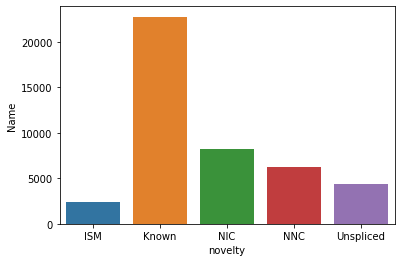

In [17]:
df = ca.ic.loc[ca.ic.source.str.contains('isoquant')].copy(deep=True)
temp = df[['novelty', 'Name']].groupby('novelty').count().reset_index()
sns.barplot(temp, y='Name', x='novelty')

<AxesSubplot:xlabel='novelty', ylabel='Name'>

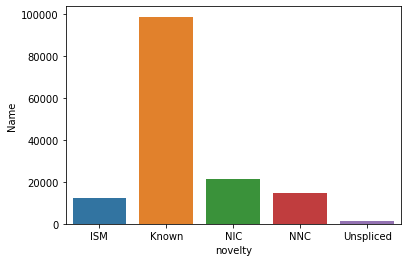

In [18]:
df = ca.ic.loc[ca.ic.source.str.contains('lapa')].copy(deep=True)
temp = df[['novelty', 'Name']].groupby('novelty').count().reset_index()
sns.barplot(temp, y='Name', x='novelty')

## Format IsoQuant abundance file

In [20]:
def format_isoquant_ab(ab, dataset, lib_meta, ofile):
    """
    Format abundance file from isoquant GFF into a format
    that Cerberus can deal with
    """
    meta = pd.read_csv(lib_meta, sep='\t')
    df = pd.read_csv(ab, sep='\t')
    df.head()
    df['annot_transcript_id'] = df['#feature_id']
    df['annot_transcript_name'] = df['annot_transcript_id']
    df['transcript_ID'] = df['annot_transcript_id']
    df.columns = [c.split('.')[0] for c in df.columns]
    df.drop('#feature_id', axis=1, inplace=True)
    m = dict([(entry['ENCODE_alignments_id'], entry['dataset']) for ind, entry in meta[['dataset', 'ENCODE_alignments_id']].iterrows()])
    df.columns = [m[c] if 'ENCFF' in c else c for c in df.columns]
    
    df.to_csv(ofile, sep='\t', index=False)

In [48]:

df.head()


,wtc11_1_1,wtc11_1_3,wtc11_1_2,annot_transcript_id,annot_transcript_name,transcript_ID
0,5.016551,4.130977,10.360410,ENST00000003583.12,ENST00000003583.12,ENST00000003583.12
1,2.315331,1.652391,6.906940,ENST00000003912.7,ENST00000003912.7,ENST00000003912.7
2,27.012200,16.523907,12.662723,ENST00000040877.1,ENST00000040877.1,ENST00000040877.1
3,12.348434,12.117532,18.418507,ENST00000054650.8,ENST00000054650.8,ENST00000054650.8
4,50.165515,40.758970,56.406677,ENST00000054666.10,ENST00000054666.10,ENST00000054666.10


In [34]:
meta = pd.read_csv(lib_meta, sep='\t')
meta.head()

,ENCODE_experiment_id,dataset,sample,sample_display,general_tissue_cell_type,fig1_tissue_label,health_status,tissue_or_cell_line,sample_color_hex_code,matching_mouse_samples,reads_post_talon,ENCODE_alignments_id,ENCODE_reads_id,ENCODE_unfiltered_alignments_id,document_urls,document_labels,platform,RIN,spikeins
0,ENCSR989ZYL,a673_1_1,a673,A673,a673,bone,NaN,cell_line,#de3700,NaN,1330194,ENCFF045ZQI,ENCFF168MIB,ENCFF440LXJ,https://www.encodeproject.org/documents/6d583a...,'ENCODE Long Read RNA-Seq Analysis Protocol fo...,Pacific Biosciences Sequel II,9.8,True
1,ENCSR989ZYL,a673_1_2,a673,A673,a673,bone,NaN,cell_line,#de3700,NaN,1707207,ENCFF320GCF,ENCFF861BKY,ENCFF240FZT,https://www.encodeproject.org/documents/6d583a...,'ENCODE Long Read RNA-Seq Analysis Protocol fo...,Pacific Biosciences Sequel II,9.8,True
2,ENCSR081NRO,adrenal_gland_1_1,adrenal_gland,Adrenal gland,adrenal gland,adrenal gland,NaN,tissue,#e69b00,"adrenal_gland,adrenal_10d,adrenal_14d,adrenal_...",765655,ENCFF147OYL,ENCFF211SQY,ENCFF967OHL,https://www.encodeproject.org/documents/54012f...,'non-size selected cDNA libraries for use in P...,Pacific Biosciences Sequel,9.8,False
3,ENCSR563RLX,adrenal_gland_2_1,adrenal_gland,Adrenal gland,adrenal gland,adrenal gland,NaN,tissue,#e69b00,"adrenal_gland,adrenal_10d,adrenal_14d,adrenal_...",1579294,ENCFF791WUV,ENCFF417ALN,ENCFF900XHI,https://www.encodeproject.org/documents/3baa46...,"'PacBio libraries v3 (October, 2020) Protocol ...",Pacific Biosciences Sequel II,NaN,True
4,ENCSR995WKW,adrenal_gland_3_1,adrenal_gland,Adrenal gland,adrenal gland,adrenal gland,NaN,tissue,#e69b00,"adrenal_gland,adrenal_10d,adrenal_14d,adrenal_...",577077,ENCFF243PFI,ENCFF912HPY,ENCFF020MWV,https://www.encodeproject.org/documents/54012f...,'non-size selected cDNA libraries for use in P...,Pacific Biosciences Sequel,9.4,False
